In [1]:
!hostname

gpu-10


In [2]:
!which python

/home/jk6373/pyenv/ssml/bin/python


In [11]:
# %load main.py

# Import required packages
import os
import re
import sys
import json
import pickle
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, precision_recall_curve

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import *

# Set seed to get reproducible results
np.random.seed(7)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

###
import torchvision.models as models
resnet18 = models.resnet18().to(device)
alexnet = models.alexnet().to(device)
vgg16 = models.vgg16().to(device)
squeezenet = models.squeezenet1_0().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)
###

##### Data Loading
DATA_ROOT = '/beegfs/bva212/openmic-2018'
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)

# len_data = Y_mask.shape[0]
# idx_train = np.random.choice(len_data, int(len_data*0.7), replace=False)
# remain_set = set(np.arange(len_data)) - set(idx_train)
# idx_test = np.random.choice(list(remain_set), int(len_data*0.1), replace=False)
# idx_val = list(remain_set - set(idx_test))

train_samples = pd.read_csv(os.path.join(DATA_ROOT,'/beegfs/bva212/openmic-2018/partitions/split01_train.csv'), names =['id']).to_numpy().squeeze()
test_samples = pd.read_csv(os.path.join(DATA_ROOT,'/beegfs/bva212/openmic-2018/partitions/split01_test.csv'), names =['id']).to_numpy().squeeze()

len_data = len(train_samples)
train_idx = np.random.choice(len_data, int(len_data*0.8), replace=False)
remain_set = list(set(np.arange(len_data))-set(train_idx))

idx_val = np.isin(sample_key, train_samples[remain_set])
idx_train = np.isin(sample_key, train_samples[train_idx])
idx_test = np.isin(sample_key, test_samples)

class CQTLoader(Dataset):

    def __init__(self, root_dir, files, mask, label):
        self.root_dir = root_dir
        self.files = files
        self.mask = mask
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = (np.load(self.root_dir + self.files[idx]+'_cqt.npy') - -24.3633)/14.2659
#         logscalogram = np.array(np.split(logscalogram[:,:logscalogram.shape[1]-logscalogram.shape[1]%3], 3, axis=1))
        label = (self.label[idx] > 0.5).astype(int)
        mask = self.mask[idx]
        return {'logscalogram': logscalogram[np.newaxis, :], 'label': label[np.newaxis, :], 'mask': mask[np.newaxis, :]}


def my_collate(batch):
    data = np.concatenate([item['logscalogram'] for item in batch], axis=0)
    data = np.expand_dims(data, axis = 1)
    
    target = np.concatenate([item['label'] for item in batch],axis=0)
    
    mask_sum = np.sum([item['mask'] for item in batch], axis=0)
    mask_sum = np.where(mask_sum == 0, 1, mask_sum)
    weight = np.concatenate([item['mask'] / mask_sum for item in batch], axis=0)
    
    return [torch.from_numpy(data).float(), torch.from_numpy(target).float(), torch.from_numpy(weight).float()]


root_dir = '/beegfs/bva212/openmic-2018/cqt_full/'
BATCH_SIZE = 32

Train_dataset = CQTLoader(root_dir, sample_key[idx_train], Y_mask[idx_train], Y_true[idx_train])
Train_loader = DataLoader(dataset = Train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                            collate_fn = my_collate
                          )

Val_dataset = CQTLoader(root_dir, sample_key[idx_val], Y_mask[idx_val], Y_true[idx_val])
Val_loader = DataLoader(dataset = Val_dataset,
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                        collate_fn = my_collate
                        )

Test_dataset = CQTLoader(root_dir, sample_key[idx_test], Y_mask[idx_test], Y_true[idx_test])
Test_loader = DataLoader(dataset = Test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True,
                        collate_fn = my_collate
                        )


# Classification Model
class AudioConvNet(nn.Module):

    def __init__(self, fc):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(AudioConvNet, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
#         self.concat_mlp_layer = nn.Sequential(nn.Linear(3072, 2048),
#                                               nn.BatchNorm1d(num_features=2048),
#                                               nn.ReLU(inplace=True),

#                                               nn.Linear(2048, 1024),
#                                               nn.BatchNorm1d(num_features=1024),
#                                               nn.ReLU(inplace=True),

#                                               nn.Linear(1024, 256),
#                                               nn.BatchNorm1d(num_features=256),
#                                               nn.ReLU(inplace=True),
#                                               )
        self.fc = fc
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, input):
        conv_strips = []
        n_strips = input.shape[1]
        for strip in range(n_strips):
            conv_strip = input[:,strip]
            conv_strip = conv_strip.unsqueeze(1)
            conv_strips.append(self.conv_layers(conv_strip))

        concat_out=torch.cat(conv_strips,1)
        output = self.fc(np.squeeze(concat_out))

        # ConvNet-Ext
#         out = self.concat_mlp_layer(concat_out.view(concat_out.shape[0], -1))
#         output = self.fc(out.view(out.shape[0], -1))

        return output

# Function for calculating results metrics
def test_model(loader, model):
    
    # Declaration
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    actual_arr = []
    predicted_arr = []
    weight_array = []
    
    model.eval()
    with torch.no_grad():
        wgt, tgt, preds, pred_probs = torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device), \
                                            torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device)
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')

            actual_arr.extend(target.view(1, -1).squeeze().numpy().astype(int).tolist())
            predicted_arr.extend(predicted.view(1, -1).squeeze().cpu().numpy().astype(int).tolist())

            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(target_batch.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
            weight_array = np.concatenate((weight_array,(weight != 0).reshape(-1).numpy().astype(int)))
            
            wgt = torch.cat((wgt, weight_batch), dim=0)
            tgt = torch.cat((tgt, target_batch), dim=0)
            preds = torch.cat((preds, predicted), dim=0)
            pred_probs = torch.cat((pred_probs, torch.sigmoid(outputs.data)), dim=0)

        # Results
        o_acc = (100 * correct / total_num)
        o_loss = (total_loss/total)
        o_f1 = f1_score(actual_arr, predicted_arr, average='micro', sample_weight=weight_array)
        class_wise_results, o_prt = {}, {}
        for instrument, label in class_map.items():
            y_true = tgt[(wgt[:,label] != 0),label].cpu()
            y_preds = preds[(wgt[:,label] != 0),label].cpu()

            class_wise_results[instrument] = classification_report(y_true, y_preds, output_dict = True)

            o_prt[instrument] = precision_recall_curve(tgt[(wgt[:, label] != 0), label].cpu(), \
                                                               pred_probs[(wgt[:, label] != 0), label].cpu())

    return o_acc, o_loss, o_f1, class_wise_results, o_prt


def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    
    # Declaration
    train_acc_list = []
    train_loss_list = []
    train_f1_list = []
    val_acc_list = []
    val_loss_list = []
    val_f1_list = []
    best_val_acc = 0
    
    model.eval()
    for epoch in range(num_epochs):
        for spectrogram, target, weight in train_loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            optimizer.zero_grad()
            outputs = model(spectrogram_batch)
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            loss.backward()
            optimizer.step()
        
        # Get results
        train_results = test_model(train_loader, model)
        val_results = test_model(val_loader, model)
        train_acc_list.append(train_results[0])
        train_loss_list.append(train_results[1])
        train_f1_list.append(train_results[2])
        val_acc_list.append(val_results[0])
        val_loss_list.append(val_results[1])
        val_f1_list.append(val_results[2])
        
        # Store best model
        if val_results[0] > best_val_acc:
            best_val_acc = val_results[0]
            best_model_state_dict = deepcopy(model.state_dict())
            best_train_class_wise_results = deepcopy(train_results[3])
            best_train_prt = deepcopy(train_results[4])
            best_val_class_wise_results = deepcopy(val_results[3])
            best_val_prt = deepcopy(val_results[4])
            
        scheduler.step(val_results[0])

        print("Epoch:{}".format(epoch + 1))
        print("Training - Accuracy: {:.2f}, Loss: {:.5f}, F1: {:.2f}".format(train_results[0], train_results[1],
                                                                                    train_results[2]))
        print("Validation - Accuracy: {:.2f}, Loss: {:.5f}, F1: {:.2f}".format(val_results[0], val_results[1],
                                                                                          val_results[2]))
        
    return train_acc_list, train_loss_list, train_f1_list, best_train_class_wise_results, best_train_prt, \
                val_acc_list, val_loss_list, val_f1_list, best_val_class_wise_results, best_val_prt, best_model_state_dict
        
        
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class SimpleMLP_Model(nn.Module):
    """
    SimpleMLP classification model
    """
    def __init__(self, in_ftr=1024, out_ftr=20):
        
        super(SimpleMLP_Model, self).__init__()
        #self.linear1 = nn.Linear(49152,512)
        #self.linear1 = nn.Linear(1024,512)
        #self.linear2 = nn.Linear(512,256)
        #self.linear3 = nn.Linear(256,10)
        self.linear = nn.Linear(in_ftr, out_ftr)
    
    
    def forward(self,x):
        #x = x.view(x.size(0), -1)
        #x = nn.Linear(x.size(0),1024)(x)
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)  
        x = self.linear(x)
        return x
#####

# Hyperparameters
lr = 0.01
num_epochs = 45

# Model Variables
model_path_list = [('','random_init', 'Random ConvNet'),
                    ('/beegfs/bva212/capstone/new_model/best_model.pth', 'time_reversal_best', 'Time Reversal ConvNet'),
                    ('/beegfs/sc6957/capstone/models/20191116/snet3_jigsaw_large_best_model.pth', 'jigsaw_3_1_best', 'Jigsaw 3*1s ConvNet'),
                    # ('/beegfs/sc6957/capstone/models/20191105/snet2_jigsaw_large_checkpoint_model_5.pth', 'jigsaw_10_3_wfc_chkpnt_5'),
                    ('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth', 'jigsaw_10_3_wfc_best', 'Jigsaw 3*3s Convnet'),
                    # ('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth', 'jigsaw_3_1_wfc_best'),
                    # ('/beegfs/bva212/capstone/new_model/checkpoint_model.pth', 'time_reversal_chkpnt_15'),
                    ('', 'random_ext_init', 'Random ConvNet-ext'),
                    ('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth', 'jigsaw_3_1_ext_best', 'Jigsaw 3*1s ConvNet-ext'),
                    ('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth', 'jigsaw_10_3_ext_best', 'Jigsaw 3*3s ConvNet-ext'),
                    ('', 'random_resnet_init', 'Random ResNet18'),
                    ('/beegfs/sc6957/capstone/models/20191123/resnet_jigsaw_large_best_model.pth', 'jigsaw_3_1_resnet_best', 'Jigsaw 3*1s ResNet18'),
                    ('/beegfs/sc6957/capstone/models/20191123/resnet_jigsaw_10_large_best_model.pth', 'jigsaw_10_3_resnet_best', 'Jigsaw 3*3s ResNet18')
                    ]

r1 = re.compile('conv_layers')
r2 = re.compile('\w*chkpnt\w*')
r3 = re.compile('\w*resnet\w*')
r4 = re.compile('mlp_layer\w*')
r5 = re.compile('fc')
r6 = re.compile('random\w*')


def run_model(model, model_path, model_suffix, train_loader):
    
    model_state_dict = None
    if r6.match(model_suffix) is None:
        if r2.match(model_suffix) is None:
            model_state_dict = torch.load(model_path)['modelStateDict']
        else:
            model_state_dict = torch.load(model_path)['bestModelStateDict']

    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            # ConvNet
            # cs = r1.search(key)
            # if cs is None:
            #     del model_state_dict[key]
            # elif cs.start() != 0:
            #     model_state_dict[key[cs.start():]] = model_state_dict[key]
            #     del model_state_dict[key]

            if r3.match(model_suffix) is None:
                # ConvNet-Ext
                n_ftr = 256
                if r4.match(key) is not None:
                    del model_state_dict[key]
            else:
                # ResNet
                n_ftr = 512
                cs = r5.search(key)
                if cs is None:
                    model_state_dict[key[len('resnet.'):]] = model_state_dict[key]
                    del model_state_dict[key]
                elif cs.start() != 0:
                    del model_state_dict[key]
        model.load_state_dict(model_state_dict)

    # Freeze
    for param in model.parameters():
            param.requires_grad = False

    # ConvNet: 1024, ConvNet-Ext: 256, ResNet: 512
    if r3.match(model_suffix) is None:
        # ConvNet-Ext
        n_ftr = 256
    else:
        # ResNet
        n_ftr = 512
    model.fc = SimpleMLP_Model(in_ftr=n_ftr, out_ftr=20)
    model.to(device)

    # Train
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=lr, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    
    # Output results
    return train_model(train_loader, Val_loader, model, optimizer, scheduler, num_epochs)

In [4]:
!sh call_ssml_code.sh 'eval'

Submitted batch job 6152643
Submitted batch job 6152644
Submitted batch job 6152645
Submitted batch job 6152646
Submitted batch job 6152647
Submitted batch job 6152648
Submitted batch job 6152649


In [4]:
# Additional packages required for analysis
from collections import OrderedDict
from matplotlib import pyplot as plt

results_path = '../../../results/'

In [5]:
model_test_results = pickle.load(open(results_path+'complete_dataset_results.pkl','rb'))
for key in model_test_results.keys():
    print(key, ': \t', model_test_results[key].keys())

random_init : 	 dict_keys(['val', 'test'])
time_reversal_best : 	 dict_keys(['val', 'test'])
jigsaw_3_1_best : 	 dict_keys(['val', 'test'])
jigsaw_10_3_wfc_best : 	 dict_keys(['val', 'test'])
random_ext_init : 	 dict_keys(['val', 'test'])
jigsaw_3_1_ext_best : 	 dict_keys(['val', 'test'])
jigsaw_10_3_ext_best : 	 dict_keys(['val', 'test'])
random_resnet_init : 	 dict_keys(['val', 'test'])
jigsaw_3_1_resnet_best : 	 dict_keys(['val', 'test'])
jigsaw_10_3_resnet_best : 	 dict_keys(['val', 'test'])


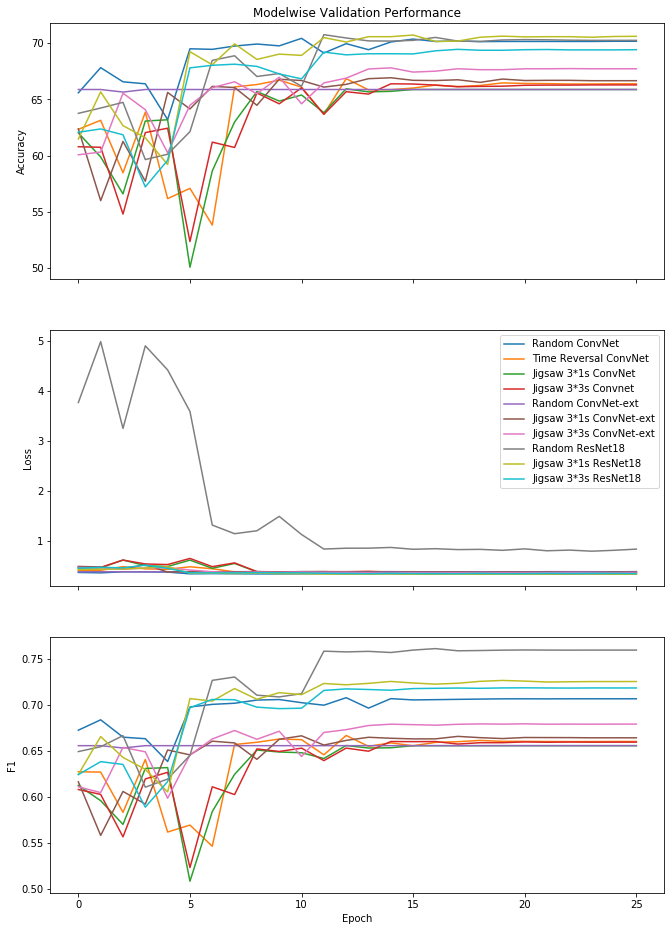

In [54]:
model_file_prefix = './model/complete_dataset/downstream_frozen_'
# model_test_results = OrderedDict()

plt_title = 'Modelwise Validation Performance'
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (11, 16), sharex=True)

r7 = re.compile('\w*ext\w*')

for _, model_suffix, model_legend in model_path_list:
    model_dict = torch.load(model_file_prefix+model_suffix)

    ax[0].plot(model_dict['val_acc_list'][:26], label=model_legend)
    ax[1].plot(model_dict['val_loss_list'][:26], label=model_legend)
    ax[2].plot(model_dict['val_f1_list'][:26], label=model_legend)

    # Calculate test performance  & store results
#     if r3.match(model_suffix) is None:
#         model = AudioConvNet(fc=Identity())
#         if r7.match(model_suffix) is None:
#             n_ftr = 1024
#         else:
#             n_ftr = 256
#     else:
#         n_ftr = 512
#         model = resnet18
    
#     model.fc = SimpleMLP_Model(in_ftr=n_ftr, out_ftr=20)
#     model.load_state_dict(model_dict['model_state_dict'])
#     model.to(device)
    
#     model_test_results[model_suffix] = {}
#     val_acc = np.array(model_dict['val_acc_list'])
#     max_val_acc = max(val_acc)
#     model_test_results[model_suffix]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]], \
#                                                                        model_dict['val_f1_list'][np.where(val_acc == max_val_acc)[0][0]], \
#                                                                     model_dict['val_class_wise_results'], model_dict['val_prt']
#                                                                   )
#     model_test_results[model_suffix]['test'] = test_model(Test_loader, model)
    
# pickle.dump(model_test_results, open(results_path+'complete_dataset_results.pkl','wb'))
    
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
ax[2].set_ylabel('F1')

ax[1].legend(loc='best')
ax[2].set_xlabel('Epoch')

ax[0].set_title(plt_title)

plt.savefig(results_path+plt_title.replace(' ', '_')+'.png')
plt.show()

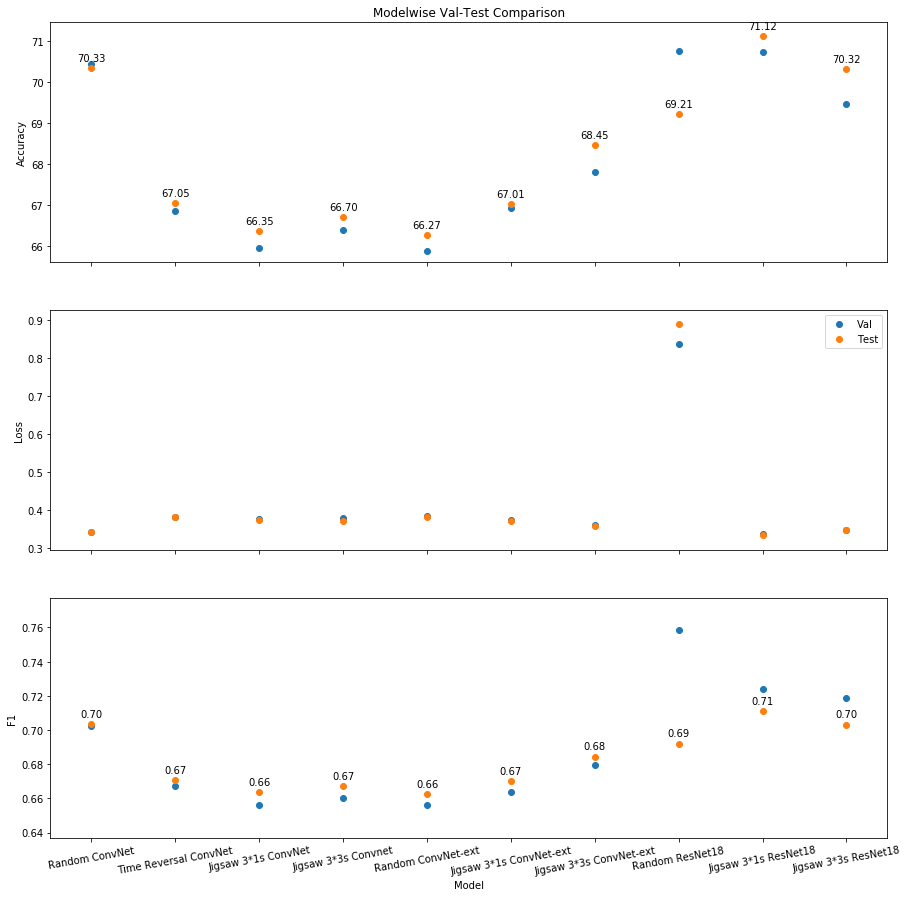

In [9]:
x = range(len(model_test_results))
key_list = np.array(model_path_list)[:,2]
values = np.array(list(model_test_results.values()))

fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (15, 15), sharex=True)
plt_title = 'Modelwise Val-Test Comparison'

ax[0].scatter(x, [value['val'][0] for value in values], label='Val')
ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
ax[0].set_ylabel('Accuracy')
ax[1].scatter(x, [value['val'][1] for value in values], label='Val')
ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
ax[1].set_ylabel('Loss')
ax[2].scatter(x, [value['val'][2] for value in values], label='Val')
ax[2].scatter(x, [value['test'][2] for value in values], label='Test')
ax[2].set_ylabel('F1')

ax[1].legend(loc='best')

ax[2].set_xticks(x)    
ax[2].set_xticklabels(key_list, rotation=10)
ax[2].set_xlabel('Model')

ax[0].set_title(plt_title)

# zip joins x and y coordinates in pairs
for xs,ys in zip(x,[value['test'][0] for value in values]):

    label = "{:.2f}".format(ys)

    ax[0].annotate(label, # this is the text
                 (xs,ys), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,7), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for xs,ys in zip(x,[value['test'][2] for value in values]):

    label = "{:.2f}".format(ys)

    ax[2].annotate(label, # this is the text
                 (xs,ys), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,7), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig(results_path+plt_title.replace(' ', '_')+'.png')
plt.show()

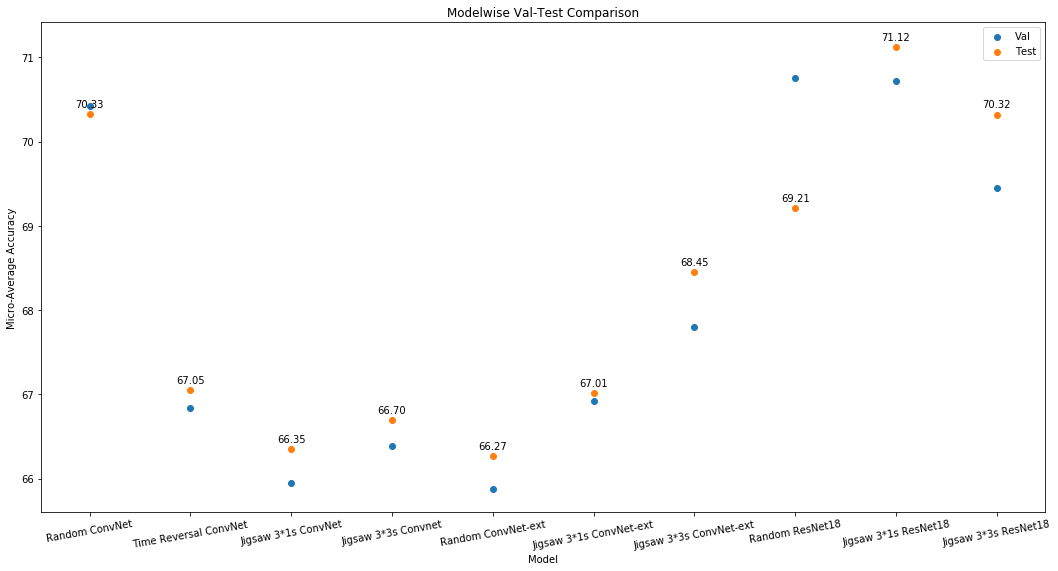

In [11]:
x = range(len(model_test_results))
key_list = np.array(model_path_list)[:,2]
values = np.array(list(model_test_results.values()))

#Plot
plt_title = 'Modelwise Val-Test Comparison'
fig = plt.figure()
fig.set_size_inches(18,9)

plt.scatter(x, [value['val'][0] for value in values], label='Val')
plt.scatter(x, [value['test'][0] for value in values], label='Test')

plt.xlabel('Model')
plt.ylabel('Micro-Average Accuracy')
plt.legend(loc='best')
plt.title(plt_title)

plt.xticks(x, key_list, rotation=10)

# # zip joins x and y coordinates in pairs
for xs,ys in zip(x,[value['test'][0] for value in values]):

    label = "{:.2f}".format(ys)

    plt.annotate(label, # this is the text
                 (xs,ys), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,7), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.savefig(results_path+plt_title.replace(' ', '_')+'-Accuracy.png')
plt.show()

-----------------------------------------------------------------------------
accordion
	Val


,precision,recall,f1-score,support
0.0,0.721875,1.000000,0.838475,231.000000
1.0,0.000000,0.000000,0.000000,89.000000
accuracy,0.721875,0.721875,0.721875,0.721875
macro avg,0.360938,0.500000,0.419238,320.000000
weighted avg,0.521104,0.721875,0.605275,320.000000


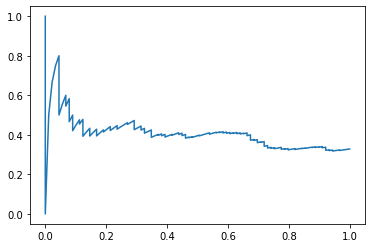


	Test


,precision,recall,f1-score,support
0.0,0.786245,1.000000,0.880333,423.000000
1.0,0.000000,0.000000,0.000000,115.000000
accuracy,0.786245,0.786245,0.786245,0.786245
macro avg,0.393123,0.500000,0.440166,538.000000
weighted avg,0.618182,0.786245,0.692158,538.000000


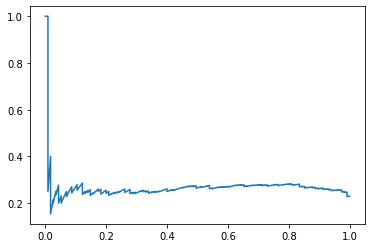

-----------------------------------------------------------------------------
banjo
	Val


,precision,recall,f1-score,support
0.0,0.666667,1.000000,0.800000,222.000000
1.0,0.000000,0.000000,0.000000,111.000000
accuracy,0.666667,0.666667,0.666667,0.666667
macro avg,0.333333,0.500000,0.400000,333.000000
weighted avg,0.444444,0.666667,0.533333,333.000000


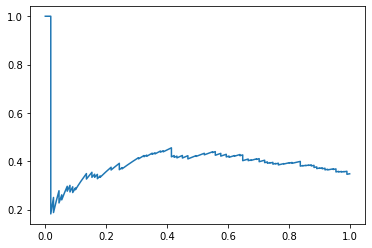


	Test


,precision,recall,f1-score,support
0.0,0.707113,1.000000,0.828431,338.000000
1.0,0.000000,0.000000,0.000000,140.000000
accuracy,0.707113,0.707113,0.707113,0.707113
macro avg,0.353556,0.500000,0.414216,478.000000
weighted avg,0.500009,0.707113,0.585795,478.000000


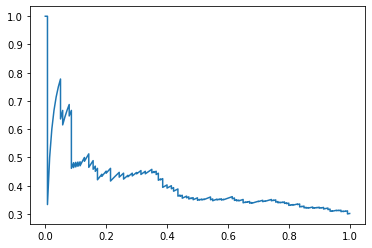

-----------------------------------------------------------------------------
bass
	Val


,precision,recall,f1-score,support
0.0,0.713693,0.891192,0.792627,193.000000
1.0,0.596154,0.310000,0.407895,100.000000
accuracy,0.692833,0.692833,0.692833,0.692833
macro avg,0.654923,0.600596,0.600261,293.000000
weighted avg,0.673577,0.692833,0.661319,293.000000


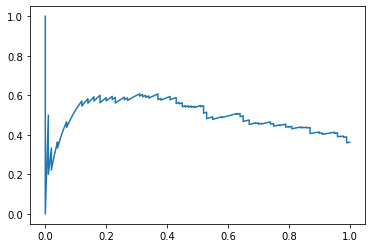


	Test


,precision,recall,f1-score,support
0.0,0.747500,0.908815,0.820302,329.000000
1.0,0.523810,0.246269,0.335025,134.000000
accuracy,0.717063,0.717063,0.717063,0.717063
macro avg,0.635655,0.577542,0.577664,463.000000
weighted avg,0.682760,0.717063,0.679855,463.000000


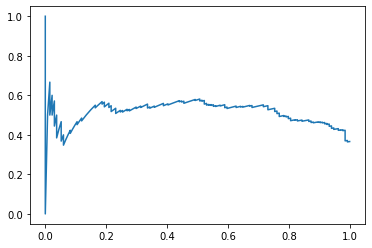

-----------------------------------------------------------------------------
cello
	Val


,precision,recall,f1-score,support
0.0,0.645985,0.967213,0.774617,183.000000
1.0,0.714286,0.133929,0.225564,112.000000
accuracy,0.650847,0.650847,0.650847,0.650847
macro avg,0.680136,0.550571,0.500090,295.000000
weighted avg,0.671916,0.650847,0.566163,295.000000


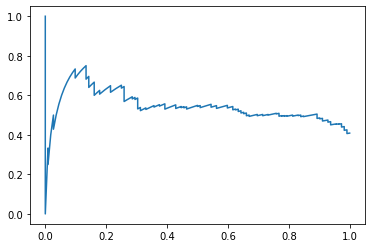


	Test


,precision,recall,f1-score,support
0.0,0.558559,0.957529,0.705548,259.000000
1.0,0.731707,0.132743,0.224719,226.000000
accuracy,0.573196,0.573196,0.573196,0.573196
macro avg,0.645133,0.545136,0.465133,485.000000
weighted avg,0.639242,0.573196,0.481491,485.000000


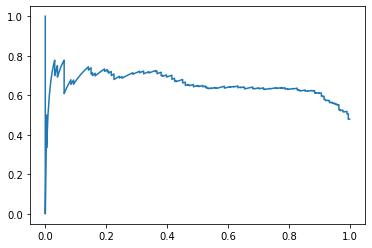

-----------------------------------------------------------------------------
clarinet
	Val


,precision,recall,f1-score,support
0.0,0.781870,1.00000,0.877583,276.00000
1.0,0.000000,0.00000,0.000000,77.00000
accuracy,0.781870,0.78187,0.781870,0.78187
macro avg,0.390935,0.50000,0.438792,353.00000
weighted avg,0.611320,0.78187,0.686156,353.00000


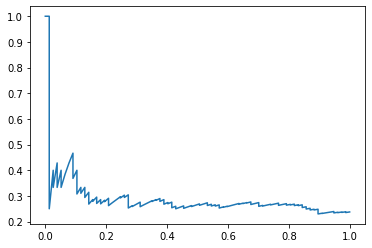


	Test


,precision,recall,f1-score,support
0.0,0.785937,1.000000,0.880140,503.000000
1.0,0.000000,0.000000,0.000000,137.000000
accuracy,0.785937,0.785937,0.785937,0.785937
macro avg,0.392969,0.500000,0.440070,640.000000
weighted avg,0.617698,0.785937,0.691735,640.000000


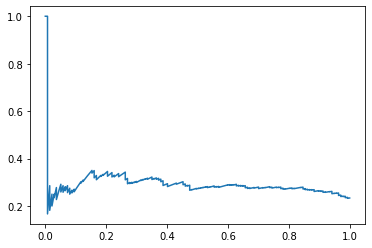

-----------------------------------------------------------------------------
cymbals
	Val


,precision,recall,f1-score,support
0.0,0.743902,0.772152,0.757764,79.000000
1.0,0.871429,0.853147,0.862191,143.000000
accuracy,0.824324,0.824324,0.824324,0.824324
macro avg,0.807666,0.812649,0.809977,222.000000
weighted avg,0.826048,0.824324,0.825030,222.000000


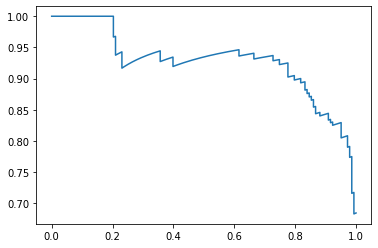


	Test


,precision,recall,f1-score,support
0.0,0.738806,0.712230,0.725275,139.000000
1.0,0.867550,0.882155,0.874791,297.000000
accuracy,0.827982,0.827982,0.827982,0.827982
macro avg,0.803178,0.797193,0.800033,436.000000
weighted avg,0.826505,0.827982,0.827124,436.000000


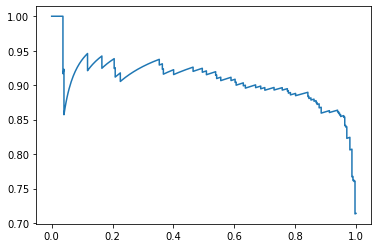

-----------------------------------------------------------------------------
drums
	Val


,precision,recall,f1-score,support
0.0,0.861111,0.704545,0.775000,88.000000
1.0,0.843373,0.933333,0.886076,150.000000
accuracy,0.848739,0.848739,0.848739,0.848739
macro avg,0.852242,0.818939,0.830538,238.000000
weighted avg,0.849932,0.848739,0.845006,238.000000


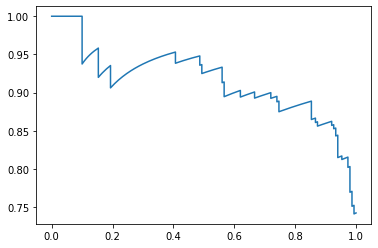


	Test


,precision,recall,f1-score,support
0.0,0.777778,0.623288,0.692015,146.000000
1.0,0.820847,0.906475,0.861538,278.000000
accuracy,0.808962,0.808962,0.808962,0.808962
macro avg,0.799312,0.764881,0.776777,424.000000
weighted avg,0.806016,0.808962,0.803165,424.000000


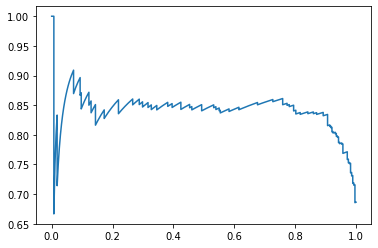

-----------------------------------------------------------------------------
flute
	Val


,precision,recall,f1-score,support
0.0,0.691558,1.000000,0.817658,213.000000
1.0,0.000000,0.000000,0.000000,95.000000
accuracy,0.691558,0.691558,0.691558,0.691558
macro avg,0.345779,0.500000,0.408829,308.000000
weighted avg,0.478253,0.691558,0.565459,308.000000


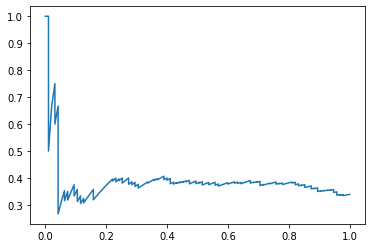


	Test


,precision,recall,f1-score,support
0.0,0.688612,1.000000,0.815595,387.000000
1.0,0.000000,0.000000,0.000000,175.000000
accuracy,0.688612,0.688612,0.688612,0.688612
macro avg,0.344306,0.500000,0.407798,562.000000
weighted avg,0.474187,0.688612,0.561629,562.000000


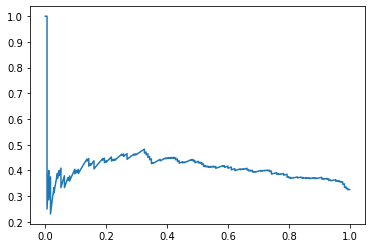

-----------------------------------------------------------------------------
guitar
	Val


,precision,recall,f1-score,support
0.0,1.000000,0.180556,0.305882,72.000000
1.0,0.748936,1.000000,0.856448,176.000000
accuracy,0.762097,0.762097,0.762097,0.762097
macro avg,0.874468,0.590278,0.581165,248.000000
weighted avg,0.821826,0.762097,0.696606,248.000000


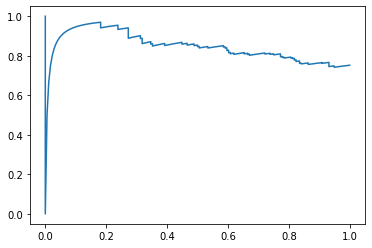


	Test


,precision,recall,f1-score,support
0.0,0.945946,0.233333,0.374332,150.000000
1.0,0.711779,0.993007,0.829197,286.000000
accuracy,0.731651,0.731651,0.731651,0.731651
macro avg,0.828863,0.613170,0.601764,436.000000
weighted avg,0.792341,0.731651,0.672707,436.000000


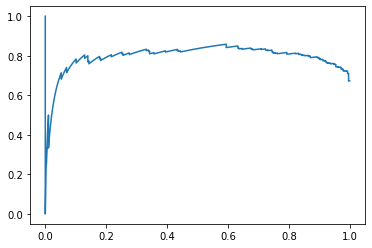

-----------------------------------------------------------------------------
mallet_percussion
	Val


,precision,recall,f1-score,support
0.0,0.621495,0.910959,0.738889,146.000000
1.0,0.580645,0.181818,0.276923,99.000000
accuracy,0.616327,0.616327,0.616327,0.616327
macro avg,0.601070,0.546389,0.507906,245.000000
weighted avg,0.604989,0.616327,0.552217,245.000000


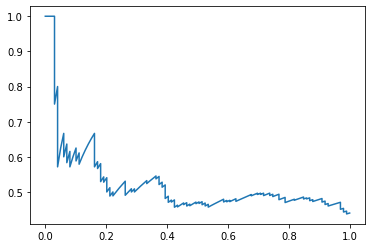


	Test


,precision,recall,f1-score,support
0.0,0.571106,0.947566,0.712676,267.000000
1.0,0.600000,0.099526,0.170732,211.000000
accuracy,0.573222,0.573222,0.573222,0.573222
macro avg,0.585553,0.523546,0.441704,478.000000
weighted avg,0.583861,0.573222,0.473450,478.000000


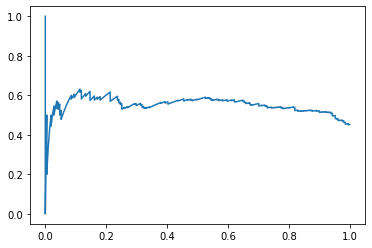

-----------------------------------------------------------------------------
mandolin
	Val


,precision,recall,f1-score,support
0.0,0.636816,1.000000,0.778116,256.000000
1.0,0.000000,0.000000,0.000000,146.000000
accuracy,0.636816,0.636816,0.636816,0.636816
macro avg,0.318408,0.500000,0.389058,402.000000
weighted avg,0.405535,0.636816,0.495516,402.000000


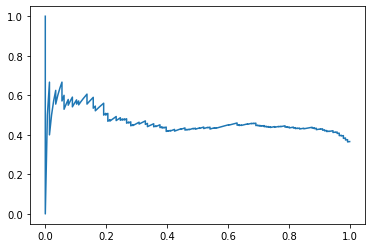


	Test


,precision,recall,f1-score,support
0.0,0.692185,1.000000,0.818096,434.000000
1.0,0.000000,0.000000,0.000000,193.000000
accuracy,0.692185,0.692185,0.692185,0.692185
macro avg,0.346093,0.500000,0.409048,627.000000
weighted avg,0.479120,0.692185,0.566274,627.000000


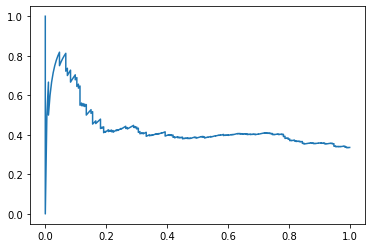

-----------------------------------------------------------------------------
organ
	Val


,precision,recall,f1-score,support
0.0,0.698675,1.000000,0.822612,211.000000
1.0,0.000000,0.000000,0.000000,91.000000
accuracy,0.698675,0.698675,0.698675,0.698675
macro avg,0.349338,0.500000,0.411306,302.000000
weighted avg,0.488147,0.698675,0.574739,302.000000


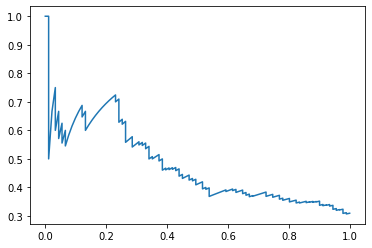


	Test


,precision,recall,f1-score,support
0.0,0.719258,1.000000,0.836707,310.000000
1.0,0.000000,0.000000,0.000000,121.000000
accuracy,0.719258,0.719258,0.719258,0.719258
macro avg,0.359629,0.500000,0.418354,431.000000
weighted avg,0.517331,0.719258,0.601808,431.000000


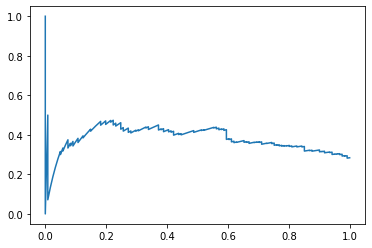

-----------------------------------------------------------------------------
piano
	Val


,precision,recall,f1-score,support
0.0,0.872340,0.561644,0.683333,73.000000
1.0,0.843902,0.966480,0.901042,179.000000
accuracy,0.849206,0.849206,0.849206,0.849206
macro avg,0.858121,0.764062,0.792188,252.000000
weighted avg,0.852140,0.849206,0.837975,252.000000


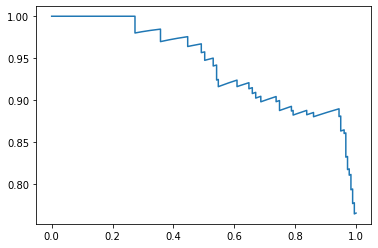


	Test


,precision,recall,f1-score,support
0.0,0.838384,0.638462,0.724891,130.000000
1.0,0.851266,0.943860,0.895175,285.000000
accuracy,0.848193,0.848193,0.848193,0.848193
macro avg,0.844825,0.791161,0.810033,415.000000
weighted avg,0.847231,0.848193,0.841833,415.000000


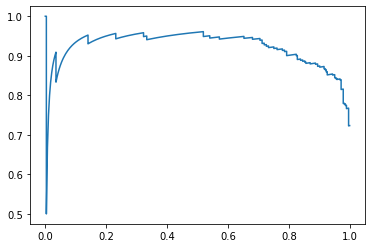

-----------------------------------------------------------------------------
saxophone
	Val


,precision,recall,f1-score,support
0.0,0.606250,0.544944,0.573964,178.000000
1.0,0.554945,0.615854,0.583815,164.000000
accuracy,0.578947,0.578947,0.578947,0.578947
macro avg,0.580598,0.580399,0.578890,342.000000
weighted avg,0.581648,0.578947,0.578688,342.000000


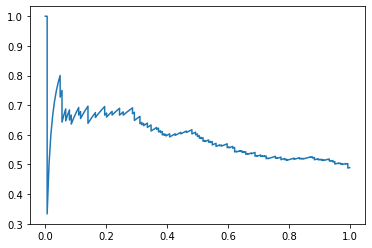


	Test


,precision,recall,f1-score,support
0.0,0.621723,0.512346,0.561760,324.000000
1.0,0.563536,0.668852,0.611694,305.000000
accuracy,0.588235,0.588235,0.588235,0.588235
macro avg,0.592629,0.590599,0.586727,629.000000
weighted avg,0.593508,0.588235,0.585973,629.000000


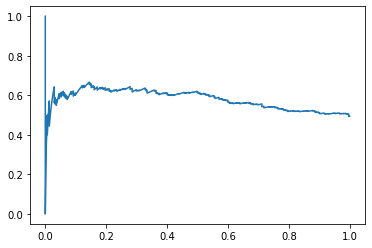

-----------------------------------------------------------------------------
synthesizer
	Val


,precision,recall,f1-score,support
0.0,0.733333,0.159420,0.261905,69.000000
1.0,0.721154,0.974026,0.828729,154.000000
accuracy,0.721973,0.721973,0.721973,0.721973
macro avg,0.727244,0.566723,0.545317,223.000000
weighted avg,0.724922,0.721973,0.653344,223.000000


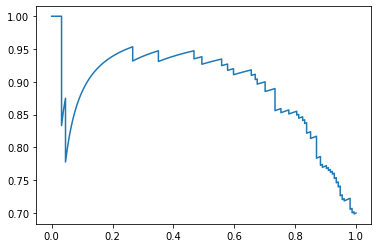


	Test


,precision,recall,f1-score,support
0.0,0.666667,0.232143,0.344371,112.000000
1.0,0.747801,0.951493,0.837438,268.000000
accuracy,0.739474,0.739474,0.739474,0.739474
macro avg,0.707234,0.591818,0.590905,380.000000
weighted avg,0.723887,0.739474,0.692113,380.000000


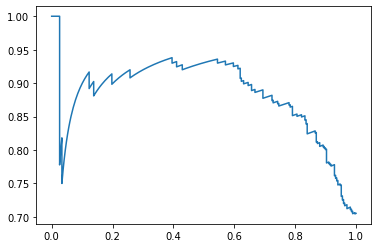

-----------------------------------------------------------------------------
trombone
	Val


,precision,recall,f1-score,support
0.0,0.673660,1.00000,0.805014,289.00000
1.0,0.000000,0.00000,0.000000,140.00000
accuracy,0.673660,0.67366,0.673660,0.67366
macro avg,0.336830,0.50000,0.402507,429.00000
weighted avg,0.453817,0.67366,0.542305,429.00000


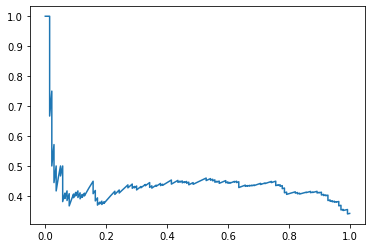


	Test


,precision,recall,f1-score,support
0.0,0.683333,1.000000,0.811881,492.000000
1.0,0.000000,0.000000,0.000000,228.000000
accuracy,0.683333,0.683333,0.683333,0.683333
macro avg,0.341667,0.500000,0.405941,720.000000
weighted avg,0.466944,0.683333,0.554785,720.000000


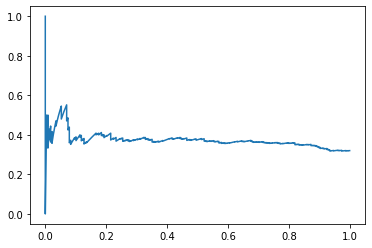

-----------------------------------------------------------------------------
trumpet
	Val


,precision,recall,f1-score,support
0.0,0.657277,0.949153,0.776699,295.000000
1.0,0.531250,0.104294,0.174359,163.000000
accuracy,0.648472,0.648472,0.648472,0.648472
macro avg,0.594263,0.526724,0.475529,458.000000
weighted avg,0.612425,0.648472,0.562329,458.000000


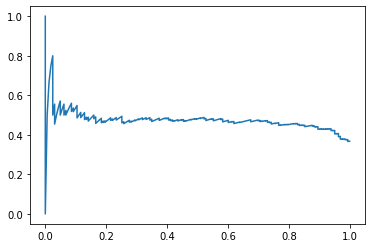


	Test


,precision,recall,f1-score,support
0.0,0.604782,0.920771,0.730051,467.000000
1.0,0.500000,0.116352,0.188776,318.000000
accuracy,0.594904,0.594904,0.594904,0.594904
macro avg,0.552391,0.518562,0.459413,785.000000
weighted avg,0.562335,0.594904,0.510783,785.000000


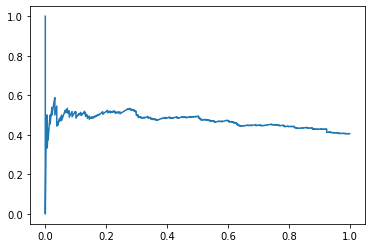

-----------------------------------------------------------------------------
ukulele
	Val


,precision,recall,f1-score,support
0.0,0.705882,1.000000,0.827586,264.000000
1.0,0.000000,0.000000,0.000000,110.000000
accuracy,0.705882,0.705882,0.705882,0.705882
macro avg,0.352941,0.500000,0.413793,374.000000
weighted avg,0.498270,0.705882,0.584178,374.000000


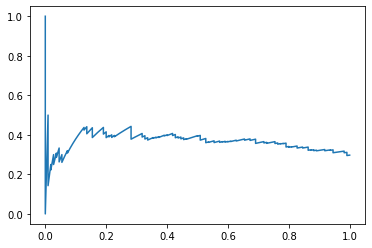


	Test


,precision,recall,f1-score,support
0.0,0.691525,1.000000,0.817635,408.000000
1.0,0.000000,0.000000,0.000000,182.000000
accuracy,0.691525,0.691525,0.691525,0.691525
macro avg,0.345763,0.500000,0.408818,590.000000
weighted avg,0.478207,0.691525,0.565416,590.000000


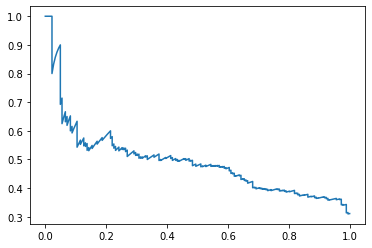

-----------------------------------------------------------------------------
violin
	Val


,precision,recall,f1-score,support
0.0,0.773196,0.585938,0.666667,128.000000
1.0,0.698864,0.848276,0.766355,145.000000
accuracy,0.725275,0.725275,0.725275,0.725275
macro avg,0.736030,0.717107,0.716511,273.000000
weighted avg,0.733715,0.725275,0.719615,273.000000


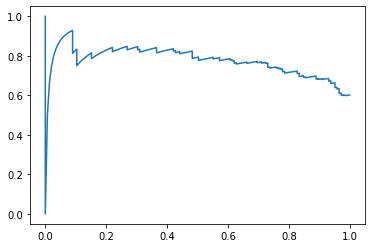


	Test


,precision,recall,f1-score,support
0.0,0.646789,0.594937,0.619780,237.000000
1.0,0.767554,0.804569,0.785626,394.000000
accuracy,0.725832,0.725832,0.725832,0.725832
macro avg,0.707172,0.699753,0.702703,631.000000
weighted avg,0.722196,0.725832,0.723335,631.000000


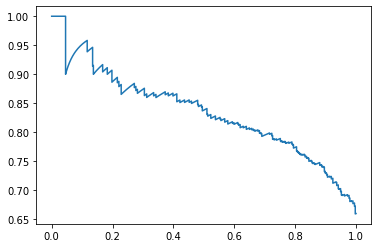

-----------------------------------------------------------------------------
voice
	Val


,precision,recall,f1-score,support
0.0,0.836735,0.471264,0.602941,87.000000
1.0,0.737143,0.941606,0.826923,137.000000
accuracy,0.758929,0.758929,0.758929,0.758929
macro avg,0.786939,0.706435,0.714932,224.000000
weighted avg,0.775824,0.758929,0.739930,224.000000


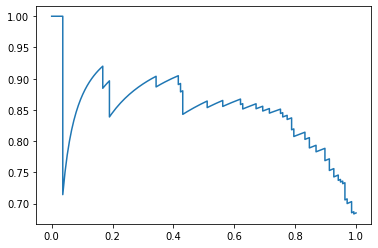


	Test


,precision,recall,f1-score,support
0.0,0.819444,0.393333,0.531532,150.000000
1.0,0.698675,0.941964,0.802281,224.000000
accuracy,0.721925,0.721925,0.721925,0.721925
macro avg,0.759060,0.667649,0.666906,374.000000
weighted avg,0.747112,0.721925,0.693692,374.000000


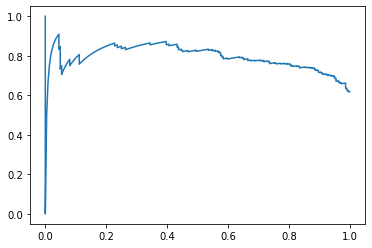

In [12]:
# Classwise results
# %%capture cap --no-stderr

from IPython.display import display, HTML

for instrument in class_map.keys():
    print('-' * 77)
    print(instrument)
    print('\tVal')
    display(HTML(pd.DataFrame(model_test_results['random_init']['val'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['random_init']['val'][4][instrument][1], model_test_results['random_init']['val'][4][instrument][0])
    plt.show()
    print('\n\tTest')
    display(HTML(pd.DataFrame(model_test_results['random_init']['test'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['random_init']['test'][4][instrument][1], model_test_results['random_init']['test'][4][instrument][0])
    plt.show()
    
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)

-----------------------------------------------------------------------------
accordion
	Val


,precision,recall,f1-score,support
0.0,0.756303,0.779221,0.767591,231.000000
1.0,0.378049,0.348315,0.362573,89.000000
accuracy,0.659375,0.659375,0.659375,0.659375
macro avg,0.567176,0.563768,0.565082,320.000000
weighted avg,0.651101,0.659375,0.654945,320.000000


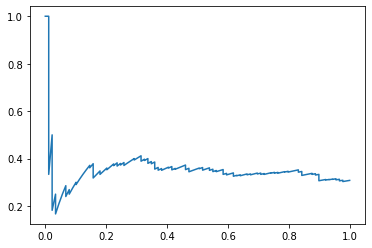


	Test


,precision,recall,f1-score,support
0.0,0.792553,0.704492,0.745932,423.000000
1.0,0.228395,0.321739,0.267148,115.000000
accuracy,0.622677,0.622677,0.622677,0.622677
macro avg,0.510474,0.513115,0.506540,538.000000
weighted avg,0.671962,0.622677,0.643590,538.000000


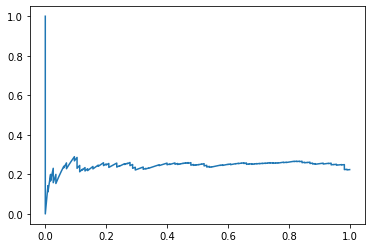

-----------------------------------------------------------------------------
banjo
	Val


,precision,recall,f1-score,support
0.0,0.720000,0.810811,0.762712,222.000000
1.0,0.493976,0.369369,0.422680,111.000000
accuracy,0.663664,0.663664,0.663664,0.663664
macro avg,0.606988,0.590090,0.592696,333.000000
weighted avg,0.644659,0.663664,0.649368,333.000000


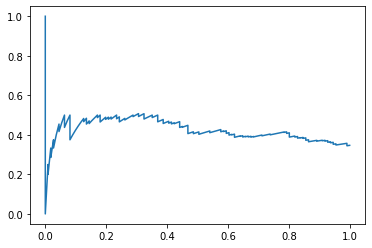


	Test


,precision,recall,f1-score,support
0.0,0.734375,0.834320,0.781163,338.000000
1.0,0.404255,0.271429,0.324786,140.000000
accuracy,0.669456,0.669456,0.669456,0.669456
macro avg,0.569315,0.552874,0.552975,478.000000
weighted avg,0.637687,0.669456,0.647496,478.000000


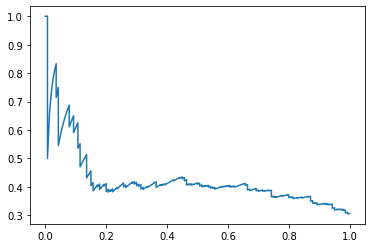

-----------------------------------------------------------------------------
bass
	Val


,precision,recall,f1-score,support
0.0,0.763285,0.818653,0.790000,193.000000
1.0,0.593023,0.510000,0.548387,100.000000
accuracy,0.713311,0.713311,0.713311,0.713311
macro avg,0.678154,0.664326,0.669194,293.000000
weighted avg,0.705175,0.713311,0.707538,293.000000


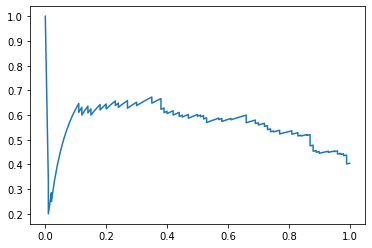


	Test


,precision,recall,f1-score,support
0.0,0.799451,0.884498,0.839827,329.000000
1.0,0.616162,0.455224,0.523605,134.000000
accuracy,0.760259,0.760259,0.760259,0.760259
macro avg,0.707806,0.669861,0.681716,463.000000
weighted avg,0.746404,0.760259,0.748307,463.000000


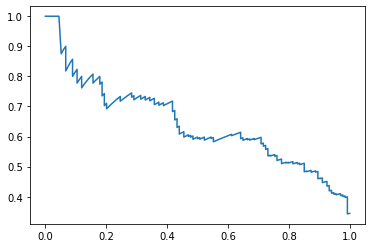

-----------------------------------------------------------------------------
cello
	Val


,precision,recall,f1-score,support
0.0,0.713542,0.748634,0.730667,183.000000
1.0,0.553398,0.508929,0.530233,112.000000
accuracy,0.657627,0.657627,0.657627,0.657627
macro avg,0.633470,0.628781,0.630450,295.000000
weighted avg,0.652741,0.657627,0.654570,295.000000


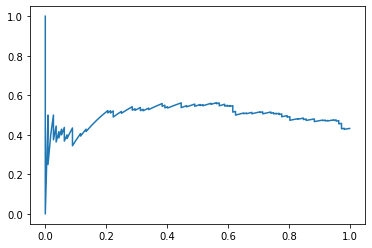


	Test


,precision,recall,f1-score,support
0.0,0.645485,0.745174,0.691756,259.000000
1.0,0.645161,0.530973,0.582524,226.000000
accuracy,0.645361,0.645361,0.645361,0.645361
macro avg,0.645323,0.638074,0.637140,485.000000
weighted avg,0.645334,0.645361,0.640856,485.000000


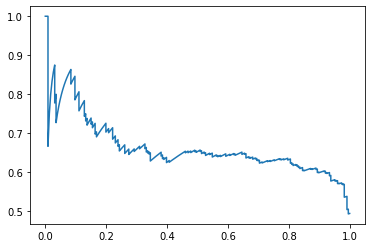

-----------------------------------------------------------------------------
clarinet
	Val


,precision,recall,f1-score,support
0.0,0.796610,0.851449,0.823117,276.000000
1.0,0.293103,0.220779,0.251852,77.000000
accuracy,0.713881,0.713881,0.713881,0.713881
macro avg,0.544857,0.536114,0.537485,353.000000
weighted avg,0.686780,0.713881,0.698507,353.000000


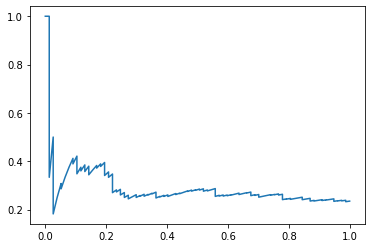


	Test


,precision,recall,f1-score,support
0.0,0.792279,0.856859,0.823305,503.000000
1.0,0.250000,0.175182,0.206009,137.000000
accuracy,0.710938,0.710938,0.710938,0.710938
macro avg,0.521140,0.516021,0.514657,640.000000
weighted avg,0.676198,0.710938,0.691165,640.000000


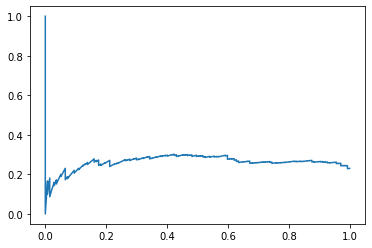

-----------------------------------------------------------------------------
cymbals
	Val


,precision,recall,f1-score,support
0.0,0.747126,0.822785,0.783133,79.000000
1.0,0.896296,0.846154,0.870504,143.000000
accuracy,0.837838,0.837838,0.837838,0.837838
macro avg,0.821711,0.834469,0.826818,222.000000
weighted avg,0.843213,0.837838,0.839412,222.000000


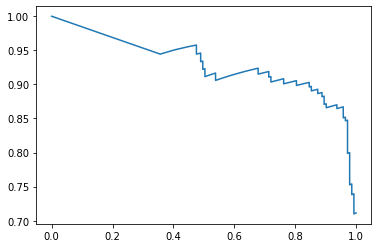


	Test


,precision,recall,f1-score,support
0.0,0.757143,0.762590,0.759857,139.00000
1.0,0.888514,0.885522,0.887015,297.00000
accuracy,0.846330,0.846330,0.846330,0.84633
macro avg,0.822828,0.824056,0.823436,436.00000
weighted avg,0.846632,0.846330,0.846476,436.00000


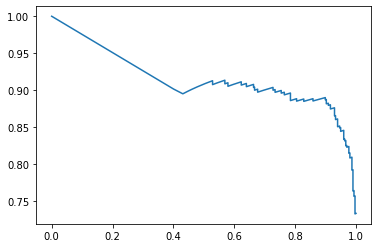

-----------------------------------------------------------------------------
drums
	Val


,precision,recall,f1-score,support
0.0,0.800000,0.681818,0.736196,88.000000
1.0,0.828221,0.900000,0.862620,150.000000
accuracy,0.819328,0.819328,0.819328,0.819328
macro avg,0.814110,0.790909,0.799408,238.000000
weighted avg,0.817786,0.819328,0.815875,238.000000


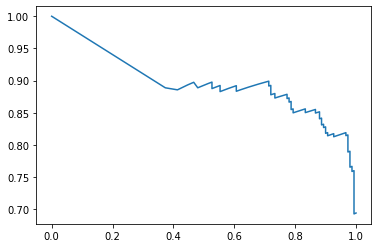


	Test


,precision,recall,f1-score,support
0.0,0.754098,0.630137,0.686567,146.000000
1.0,0.821192,0.892086,0.855172,278.000000
accuracy,0.801887,0.801887,0.801887,0.801887
macro avg,0.787645,0.761112,0.770870,424.000000
weighted avg,0.798089,0.801887,0.797115,424.000000


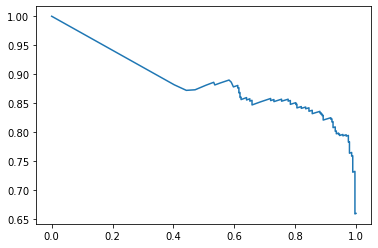

-----------------------------------------------------------------------------
flute
	Val


,precision,recall,f1-score,support
0.0,0.733333,0.774648,0.753425,213.000000
1.0,0.421687,0.368421,0.393258,95.000000
accuracy,0.649351,0.649351,0.649351,0.649351
macro avg,0.577510,0.571534,0.573342,308.000000
weighted avg,0.637209,0.649351,0.642334,308.000000


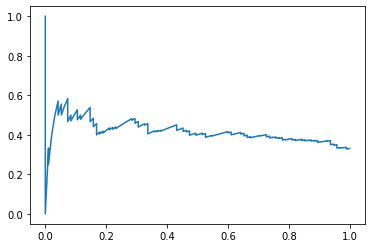


	Test


,precision,recall,f1-score,support
0.0,0.744417,0.775194,0.759494,387.000000
1.0,0.452830,0.411429,0.431138,175.000000
accuracy,0.661922,0.661922,0.661922,0.661922
macro avg,0.598624,0.593311,0.595316,562.000000
weighted avg,0.653620,0.661922,0.657248,562.000000


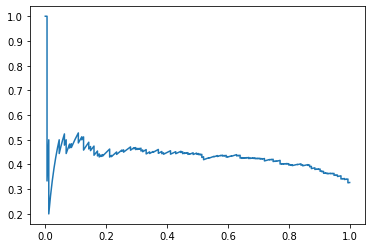

-----------------------------------------------------------------------------
guitar
	Val


,precision,recall,f1-score,support
0.0,0.563218,0.680556,0.616352,72.000000
1.0,0.857143,0.784091,0.818991,176.000000
accuracy,0.754032,0.754032,0.754032,0.754032
macro avg,0.710181,0.732323,0.717672,248.000000
weighted avg,0.771810,0.754032,0.760160,248.000000


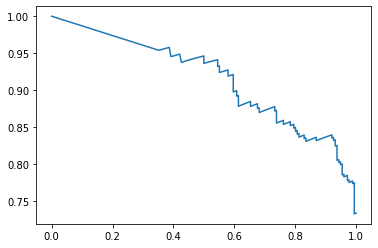


	Test


,precision,recall,f1-score,support
0.0,0.634615,0.660000,0.647059,150.000000
1.0,0.817857,0.800699,0.809187,286.000000
accuracy,0.752294,0.752294,0.752294,0.752294
macro avg,0.726236,0.730350,0.728123,436.000000
weighted avg,0.754815,0.752294,0.753409,436.000000


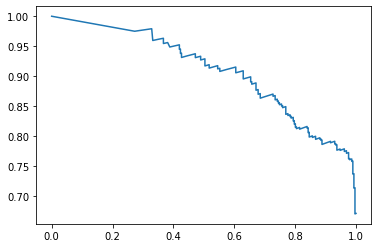

-----------------------------------------------------------------------------
mallet_percussion
	Val


,precision,recall,f1-score,support
0.0,0.704225,0.684932,0.694444,146.000000
1.0,0.553398,0.575758,0.564356,99.000000
accuracy,0.640816,0.640816,0.640816,0.640816
macro avg,0.628812,0.630345,0.629400,245.000000
weighted avg,0.643279,0.640816,0.641878,245.000000


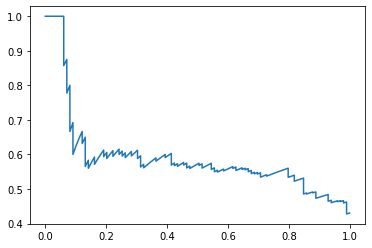


	Test


,precision,recall,f1-score,support
0.0,0.647287,0.625468,0.636190,267.000000
1.0,0.545455,0.568720,0.556845,211.000000
accuracy,0.600418,0.600418,0.600418,0.600418
macro avg,0.596371,0.597094,0.596518,478.000000
weighted avg,0.602336,0.600418,0.601165,478.000000


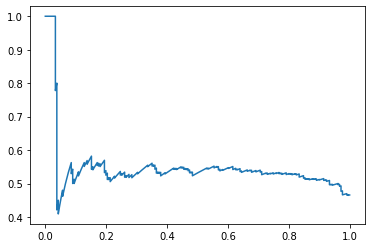

-----------------------------------------------------------------------------
mandolin
	Val


,precision,recall,f1-score,support
0.0,0.698885,0.734375,0.716190,256.000000
1.0,0.488722,0.445205,0.465950,146.000000
accuracy,0.629353,0.629353,0.629353,0.629353
macro avg,0.593803,0.589790,0.591070,402.000000
weighted avg,0.622557,0.629353,0.625307,402.000000


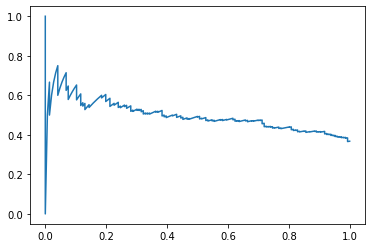


	Test


,precision,recall,f1-score,support
0.0,0.750577,0.748848,0.749712,434.000000
1.0,0.438144,0.440415,0.439276,193.000000
accuracy,0.653907,0.653907,0.653907,0.653907
macro avg,0.594361,0.594631,0.594494,627.000000
weighted avg,0.654406,0.653907,0.654155,627.000000


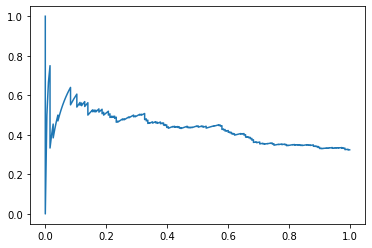

-----------------------------------------------------------------------------
organ
	Val


,precision,recall,f1-score,support
0.0,0.817204,0.720379,0.765743,211.000000
1.0,0.491379,0.626374,0.550725,91.000000
accuracy,0.692053,0.692053,0.692053,0.692053
macro avg,0.654292,0.673376,0.658234,302.000000
weighted avg,0.719025,0.692053,0.700953,302.000000


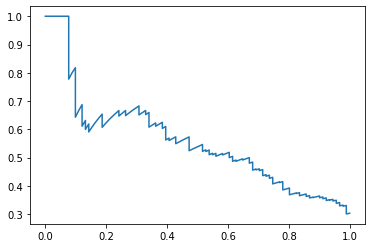


	Test


,precision,recall,f1-score,support
0.0,0.773770,0.761290,0.767480,310.000000
1.0,0.412698,0.429752,0.421053,121.000000
accuracy,0.668213,0.668213,0.668213,0.668213
macro avg,0.593234,0.595521,0.594266,431.000000
weighted avg,0.672402,0.668213,0.670223,431.000000


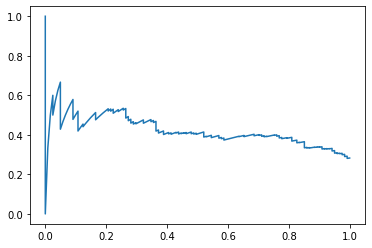

-----------------------------------------------------------------------------
piano
	Val


,precision,recall,f1-score,support
0.0,0.863636,0.780822,0.820144,73.000000
1.0,0.913978,0.949721,0.931507,179.000000
accuracy,0.900794,0.900794,0.900794,0.900794
macro avg,0.888807,0.865271,0.875825,252.000000
weighted avg,0.899395,0.900794,0.899247,252.000000


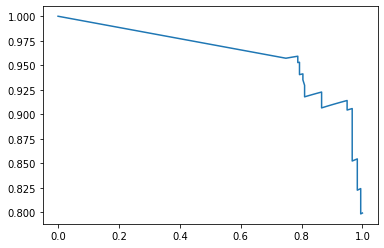


	Test


,precision,recall,f1-score,support
0.0,0.759398,0.776923,0.768061,130.000000
1.0,0.897163,0.887719,0.892416,285.000000
accuracy,0.853012,0.853012,0.853012,0.853012
macro avg,0.828281,0.832321,0.830239,415.000000
weighted avg,0.854008,0.853012,0.853462,415.000000


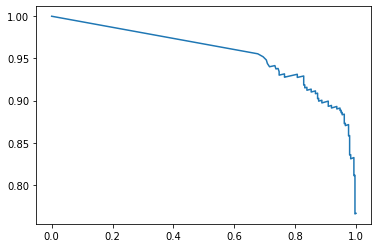

-----------------------------------------------------------------------------
saxophone
	Val


,precision,recall,f1-score,support
0.0,0.644444,0.651685,0.648045,178.000000
1.0,0.617284,0.609756,0.613497,164.000000
accuracy,0.631579,0.631579,0.631579,0.631579
macro avg,0.630864,0.630721,0.630771,342.000000
weighted avg,0.631420,0.631579,0.631478,342.000000


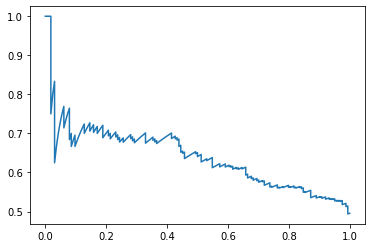


	Test


,precision,recall,f1-score,support
0.0,0.618343,0.645062,0.631420,324.000000
1.0,0.604811,0.577049,0.590604,305.000000
accuracy,0.612083,0.612083,0.612083,0.612083
macro avg,0.611577,0.611055,0.611012,629.000000
weighted avg,0.611781,0.612083,0.611628,629.000000


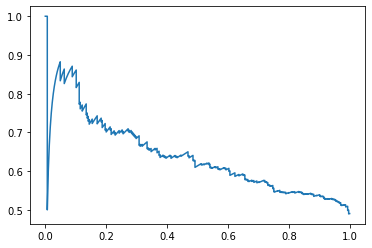

-----------------------------------------------------------------------------
synthesizer
	Val


,precision,recall,f1-score,support
0.0,0.707692,0.666667,0.686567,69.000000
1.0,0.854430,0.876623,0.865385,154.000000
accuracy,0.811659,0.811659,0.811659,0.811659
macro avg,0.781061,0.771645,0.775976,223.000000
weighted avg,0.809027,0.811659,0.810055,223.000000


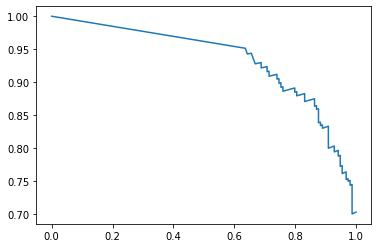


	Test


,precision,recall,f1-score,support
0.0,0.638889,0.616071,0.627273,112.000000
1.0,0.841912,0.854478,0.848148,268.000000
accuracy,0.784211,0.784211,0.784211,0.784211
macro avg,0.740400,0.735275,0.737710,380.000000
weighted avg,0.782073,0.784211,0.783048,380.000000


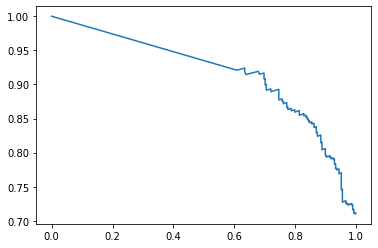

-----------------------------------------------------------------------------
trombone
	Val


,precision,recall,f1-score,support
0.0,0.748387,0.802768,0.774624,289.000000
1.0,0.521008,0.442857,0.478764,140.000000
accuracy,0.685315,0.685315,0.685315,0.685315
macro avg,0.634698,0.622813,0.626694,429.000000
weighted avg,0.674184,0.685315,0.678073,429.000000


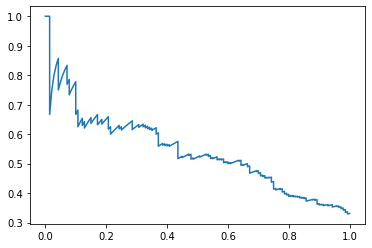


	Test


,precision,recall,f1-score,support
0.0,0.726592,0.788618,0.756335,492.000000
1.0,0.440860,0.359649,0.396135,228.000000
accuracy,0.652778,0.652778,0.652778,0.652778
macro avg,0.583726,0.574134,0.576235,720.000000
weighted avg,0.636110,0.652778,0.642272,720.000000


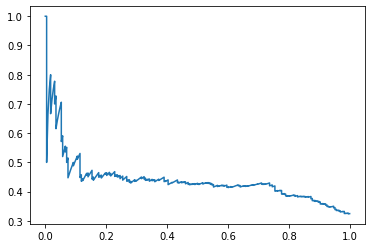

-----------------------------------------------------------------------------
trumpet
	Val


,precision,recall,f1-score,support
0.0,0.745399,0.823729,0.782609,295.00000
1.0,0.606061,0.490798,0.542373,163.00000
accuracy,0.705240,0.705240,0.705240,0.70524
macro avg,0.675730,0.657263,0.662491,458.00000
weighted avg,0.695809,0.705240,0.697110,458.00000


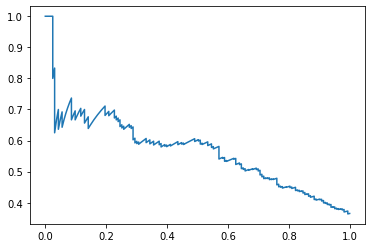


	Test


,precision,recall,f1-score,support
0.0,0.670391,0.770878,0.717131,467.000000
1.0,0.568548,0.443396,0.498233,318.000000
accuracy,0.638217,0.638217,0.638217,0.638217
macro avg,0.619470,0.607137,0.607682,785.000000
weighted avg,0.629135,0.638217,0.628457,785.000000


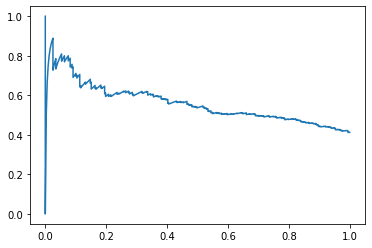

-----------------------------------------------------------------------------
ukulele
	Val


,precision,recall,f1-score,support
0.0,0.755245,0.818182,0.785455,264.000000
1.0,0.454545,0.363636,0.404040,110.000000
accuracy,0.684492,0.684492,0.684492,0.684492
macro avg,0.604895,0.590909,0.594747,374.000000
weighted avg,0.666804,0.684492,0.673274,374.000000


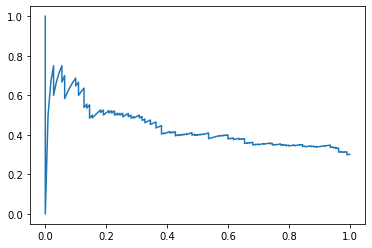


	Test


,precision,recall,f1-score,support
0.0,0.749436,0.813725,0.780259,408.000000
1.0,0.482993,0.390110,0.431611,182.000000
accuracy,0.683051,0.683051,0.683051,0.683051
macro avg,0.616214,0.601918,0.605935,590.000000
weighted avg,0.667245,0.683051,0.672710,590.000000


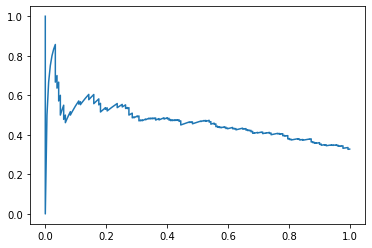

-----------------------------------------------------------------------------
violin
	Val


,precision,recall,f1-score,support
0.0,0.659574,0.726562,0.691450,128.000000
1.0,0.734848,0.668966,0.700361,145.000000
accuracy,0.695971,0.695971,0.695971,0.695971
macro avg,0.697211,0.697764,0.695905,273.000000
weighted avg,0.699555,0.695971,0.696183,273.000000


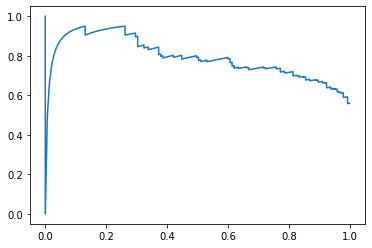


	Test


,precision,recall,f1-score,support
0.0,0.535385,0.734177,0.619217,237.000000
1.0,0.794118,0.616751,0.694286,394.000000
accuracy,0.660856,0.660856,0.660856,0.660856
macro avg,0.664751,0.675464,0.656751,631.000000
weighted avg,0.696939,0.660856,0.666090,631.000000


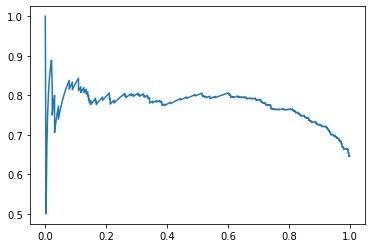

-----------------------------------------------------------------------------
voice
	Val


,precision,recall,f1-score,support
0.0,0.769231,0.689655,0.727273,87.000000
1.0,0.815068,0.868613,0.840989,137.000000
accuracy,0.799107,0.799107,0.799107,0.799107
macro avg,0.792150,0.779134,0.784131,224.000000
weighted avg,0.797265,0.799107,0.796823,224.000000


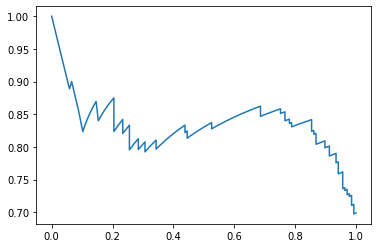


	Test


,precision,recall,f1-score,support
0.0,0.752066,0.606667,0.671587,150.000000
1.0,0.766798,0.866071,0.813417,224.000000
accuracy,0.762032,0.762032,0.762032,0.762032
macro avg,0.759432,0.736369,0.742502,374.000000
weighted avg,0.760890,0.762032,0.756533,374.000000


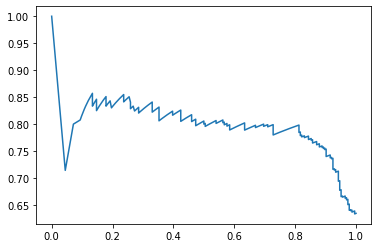

In [13]:
# Classwise results
# %%capture cap --no-stderr

from IPython.display import display, HTML

for instrument in class_map.keys():
    print('-' * 77)
    print(instrument)
    print('\tVal')
    display(HTML(pd.DataFrame(model_test_results['random_resnet_init']['val'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['random_resnet_init']['val'][4][instrument][1], model_test_results['random_resnet_init']['val'][4][instrument][0])
    plt.show()
    print('\n\tTest')
    display(HTML(pd.DataFrame(model_test_results['random_resnet_init']['test'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['random_resnet_init']['test'][4][instrument][1], model_test_results['random_resnet_init']['test'][4][instrument][0])
    plt.show()
    
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)

-----------------------------------------------------------------------------
accordion
	Val


,precision,recall,f1-score,support
0.0,0.719243,0.987013,0.832117,231.0000
1.0,0.000000,0.000000,0.000000,89.0000
accuracy,0.712500,0.712500,0.712500,0.7125
macro avg,0.359621,0.493506,0.416058,320.0000
weighted avg,0.519203,0.712500,0.600684,320.0000


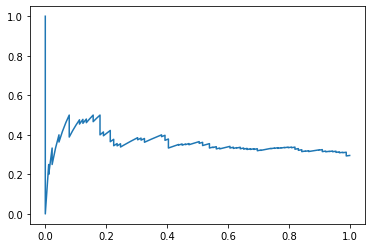


	Test


,precision,recall,f1-score,support
0.0,0.787992,0.992908,0.878661,423.000000
1.0,0.400000,0.017391,0.033333,115.000000
accuracy,0.784387,0.784387,0.784387,0.784387
macro avg,0.593996,0.505150,0.455997,538.000000
weighted avg,0.705057,0.784387,0.697968,538.000000


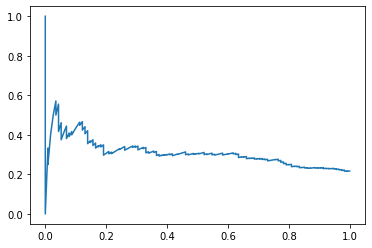

-----------------------------------------------------------------------------
banjo
	Val


,precision,recall,f1-score,support
0.0,0.668919,0.891892,0.764479,222.000000
1.0,0.351351,0.117117,0.175676,111.000000
accuracy,0.633634,0.633634,0.633634,0.633634
macro avg,0.510135,0.504505,0.470077,333.000000
weighted avg,0.563063,0.633634,0.568211,333.000000


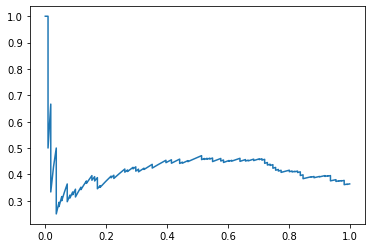


	Test


,precision,recall,f1-score,support
0.0,0.733796,0.937870,0.823377,338.000000
1.0,0.543478,0.178571,0.268817,140.000000
accuracy,0.715481,0.715481,0.715481,0.715481
macro avg,0.638637,0.558221,0.546097,478.000000
weighted avg,0.678055,0.715481,0.660953,478.000000


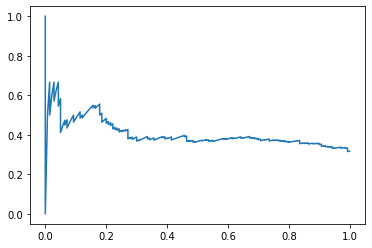

-----------------------------------------------------------------------------
bass
	Val


,precision,recall,f1-score,support
0.0,0.676471,0.953368,0.791398,193.000000
1.0,0.571429,0.120000,0.198347,100.000000
accuracy,0.668942,0.668942,0.668942,0.668942
macro avg,0.623950,0.536684,0.494872,293.000000
weighted avg,0.640620,0.668942,0.588991,293.000000


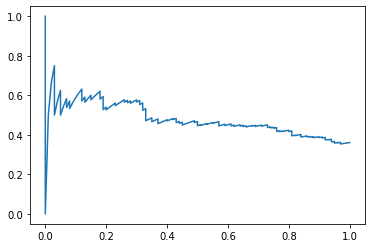


	Test


,precision,recall,f1-score,support
0.0,0.722864,0.951368,0.821522,329.000000
1.0,0.466667,0.104478,0.170732,134.000000
accuracy,0.706263,0.706263,0.706263,0.706263
macro avg,0.594765,0.527923,0.496127,463.000000
weighted avg,0.648716,0.706263,0.633173,463.000000


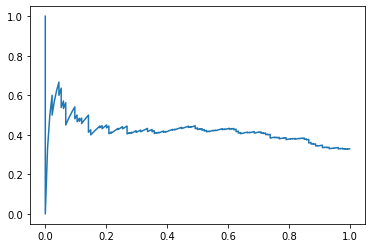

-----------------------------------------------------------------------------
cello
	Val


,precision,recall,f1-score,support
0.0,0.693396,0.803279,0.744304,183.000000
1.0,0.566265,0.419643,0.482051,112.000000
accuracy,0.657627,0.657627,0.657627,0.657627
macro avg,0.629831,0.611461,0.613178,295.000000
weighted avg,0.645129,0.657627,0.644737,295.000000


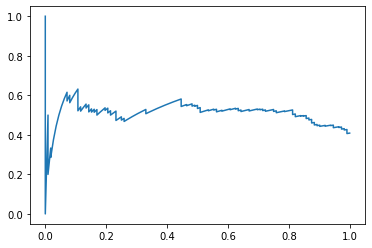


	Test


,precision,recall,f1-score,support
0.0,0.596730,0.845560,0.699681,259.000000
1.0,0.661017,0.345133,0.453488,226.000000
accuracy,0.612371,0.612371,0.612371,0.612371
macro avg,0.628874,0.595346,0.576584,485.000000
weighted avg,0.626687,0.612371,0.584960,485.000000


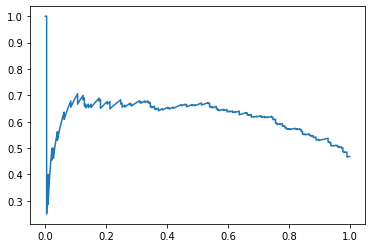

-----------------------------------------------------------------------------
clarinet
	Val


,precision,recall,f1-score,support
0.0,0.785100,0.992754,0.876800,276.00000
1.0,0.500000,0.025974,0.049383,77.00000
accuracy,0.781870,0.781870,0.781870,0.78187
macro avg,0.642550,0.509364,0.463091,353.00000
weighted avg,0.722911,0.781870,0.696315,353.00000


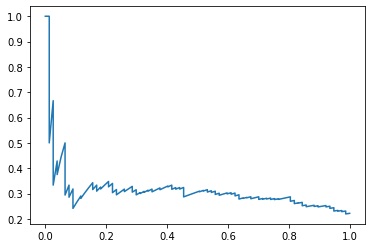


	Test


,precision,recall,f1-score,support
0.0,0.791469,0.996024,0.882042,503.000000
1.0,0.714286,0.036496,0.069444,137.000000
accuracy,0.790625,0.790625,0.790625,0.790625
macro avg,0.752877,0.516260,0.475743,640.000000
weighted avg,0.774947,0.790625,0.708096,640.000000


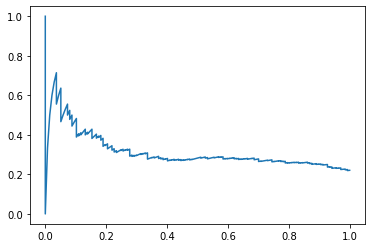

-----------------------------------------------------------------------------
cymbals
	Val


,precision,recall,f1-score,support
0.0,0.708333,0.645570,0.675497,79.000000
1.0,0.813333,0.853147,0.832765,143.000000
accuracy,0.779279,0.779279,0.779279,0.779279
macro avg,0.760833,0.749358,0.754131,222.000000
weighted avg,0.775968,0.779279,0.776800,222.000000


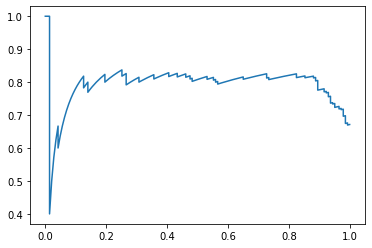


	Test


,precision,recall,f1-score,support
0.0,0.641379,0.669065,0.654930,139.000000
1.0,0.841924,0.824916,0.833333,297.000000
accuracy,0.775229,0.775229,0.775229,0.775229
macro avg,0.741652,0.746990,0.744131,436.000000
weighted avg,0.777989,0.775229,0.776457,436.000000


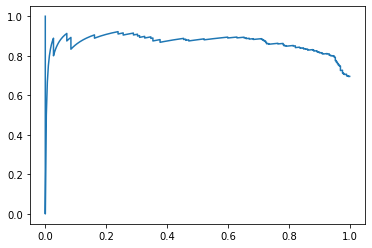

-----------------------------------------------------------------------------
drums
	Val


,precision,recall,f1-score,support
0.0,0.849057,0.511364,0.638298,88.000000
1.0,0.767568,0.946667,0.847761,150.000000
accuracy,0.785714,0.785714,0.785714,0.785714
macro avg,0.808312,0.729015,0.743030,238.000000
weighted avg,0.797698,0.785714,0.770313,238.000000


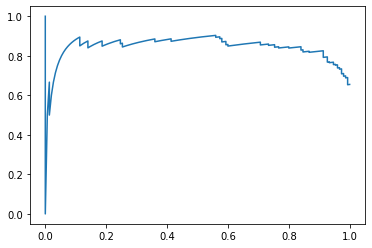


	Test


,precision,recall,f1-score,support
0.0,0.840426,0.541096,0.658333,146.000000
1.0,0.796970,0.946043,0.865132,278.000000
accuracy,0.806604,0.806604,0.806604,0.806604
macro avg,0.818698,0.743570,0.761732,424.000000
weighted avg,0.811933,0.806604,0.793923,424.000000


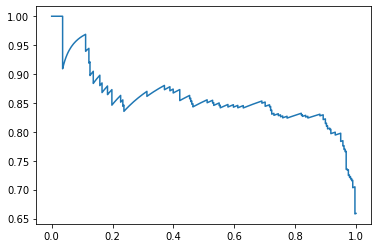

-----------------------------------------------------------------------------
flute
	Val


,precision,recall,f1-score,support
0.0,0.695652,0.976526,0.812500,213.000000
1.0,0.444444,0.042105,0.076923,95.000000
accuracy,0.688312,0.688312,0.688312,0.688312
macro avg,0.570048,0.509316,0.444712,308.000000
weighted avg,0.618169,0.688312,0.585618,308.000000


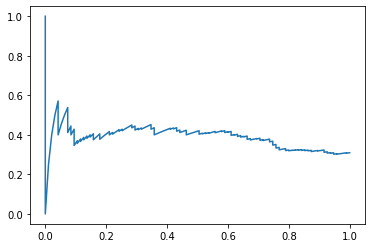


	Test


,precision,recall,f1-score,support
0.0,0.691589,0.956072,0.802603,387.000000
1.0,0.370370,0.057143,0.099010,175.000000
accuracy,0.676157,0.676157,0.676157,0.676157
macro avg,0.530980,0.506608,0.450806,562.000000
weighted avg,0.591565,0.676157,0.583513,562.000000


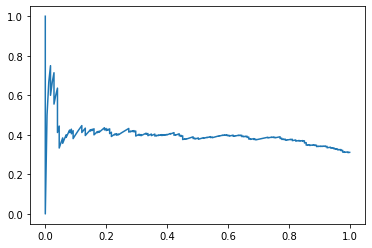

-----------------------------------------------------------------------------
guitar
	Val


,precision,recall,f1-score,support
0.0,0.555556,0.069444,0.123457,72.00000
1.0,0.719665,0.977273,0.828916,176.00000
accuracy,0.713710,0.713710,0.713710,0.71371
macro avg,0.637610,0.523359,0.476186,248.00000
weighted avg,0.672021,0.713710,0.624105,248.00000


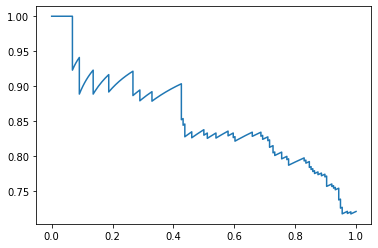


	Test


,precision,recall,f1-score,support
0.0,0.875000,0.140000,0.241379,150.000000
1.0,0.686893,0.989510,0.810888,286.000000
accuracy,0.697248,0.697248,0.697248,0.697248
macro avg,0.780947,0.564755,0.526134,436.000000
weighted avg,0.751609,0.697248,0.614956,436.000000


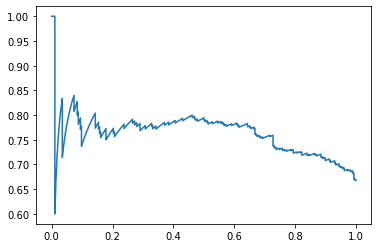

-----------------------------------------------------------------------------
mallet_percussion
	Val


,precision,recall,f1-score,support
0.0,0.621891,0.856164,0.720461,146.000000
1.0,0.522727,0.232323,0.321678,99.000000
accuracy,0.604082,0.604082,0.604082,0.604082
macro avg,0.572309,0.544244,0.521070,245.000000
weighted avg,0.581820,0.604082,0.559320,245.000000


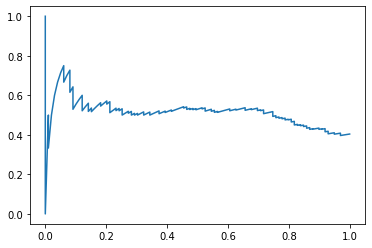


	Test


,precision,recall,f1-score,support
0.0,0.588832,0.868914,0.701967,267.000000
1.0,0.583333,0.232227,0.332203,211.000000
accuracy,0.587866,0.587866,0.587866,0.587866
macro avg,0.586083,0.550571,0.517085,478.000000
weighted avg,0.586405,0.587866,0.538745,478.000000


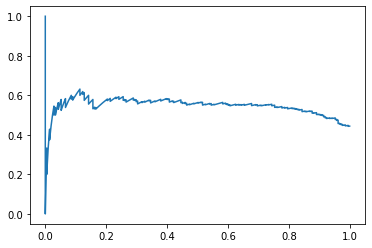

-----------------------------------------------------------------------------
mandolin
	Val


,precision,recall,f1-score,support
0.0,0.653409,0.898438,0.756579,256.000000
1.0,0.480000,0.164384,0.244898,146.000000
accuracy,0.631841,0.631841,0.631841,0.631841
macro avg,0.566705,0.531411,0.500738,402.000000
weighted avg,0.590430,0.631841,0.570745,402.000000


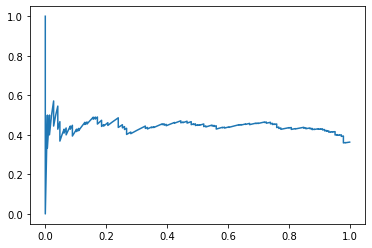


	Test


,precision,recall,f1-score,support
0.0,0.715084,0.884793,0.790937,434.000000
1.0,0.444444,0.207254,0.282686,193.000000
accuracy,0.676236,0.676236,0.676236,0.676236
macro avg,0.579764,0.546023,0.536811,627.000000
weighted avg,0.631777,0.676236,0.634490,627.000000


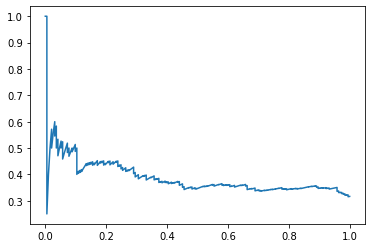

-----------------------------------------------------------------------------
organ
	Val


,precision,recall,f1-score,support
0.0,0.775510,0.900474,0.833333,211.000000
1.0,0.631579,0.395604,0.486486,91.000000
accuracy,0.748344,0.748344,0.748344,0.748344
macro avg,0.703545,0.648039,0.659910,302.000000
weighted avg,0.732140,0.748344,0.728820,302.000000


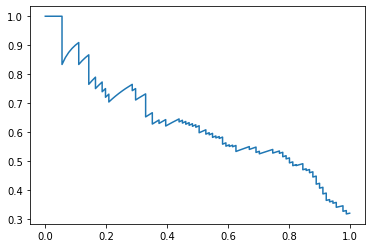


	Test


,precision,recall,f1-score,support
0.0,0.745205,0.877419,0.805926,310.000000
1.0,0.424242,0.231405,0.299465,121.000000
accuracy,0.696056,0.696056,0.696056,0.696056
macro avg,0.584724,0.554412,0.552696,431.000000
weighted avg,0.655098,0.696056,0.663741,431.000000


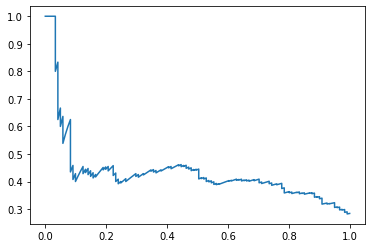

-----------------------------------------------------------------------------
piano
	Val


,precision,recall,f1-score,support
0.0,0.708333,0.465753,0.561983,73.000000
1.0,0.808824,0.921788,0.861619,179.000000
accuracy,0.789683,0.789683,0.789683,0.789683
macro avg,0.758578,0.693771,0.711801,252.000000
weighted avg,0.779713,0.789683,0.774820,252.000000


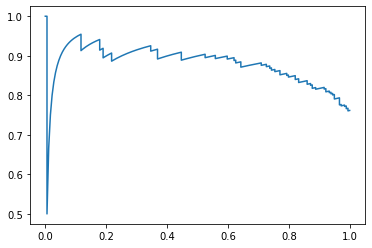


	Test


,precision,recall,f1-score,support
0.0,0.742268,0.553846,0.634361,130.0
1.0,0.817610,0.912281,0.862355,285.0
accuracy,0.800000,0.800000,0.800000,0.8
macro avg,0.779939,0.733063,0.748358,415.0
weighted avg,0.794009,0.800000,0.790935,415.0


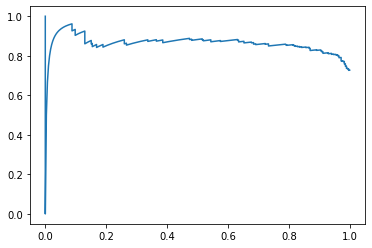

-----------------------------------------------------------------------------
saxophone
	Val


,precision,recall,f1-score,support
0.0,0.620000,0.696629,0.656085,178.000000
1.0,0.619718,0.536585,0.575163,164.000000
accuracy,0.619883,0.619883,0.619883,0.619883
macro avg,0.619859,0.616607,0.615624,342.000000
weighted avg,0.619865,0.619883,0.617280,342.000000


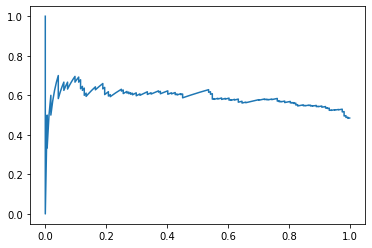


	Test


,precision,recall,f1-score,support
0.0,0.623269,0.694444,0.656934,324.000000
1.0,0.630597,0.554098,0.589878,305.000000
accuracy,0.626391,0.626391,0.626391,0.626391
macro avg,0.626933,0.624271,0.623406,629.000000
weighted avg,0.626822,0.626391,0.624419,629.000000


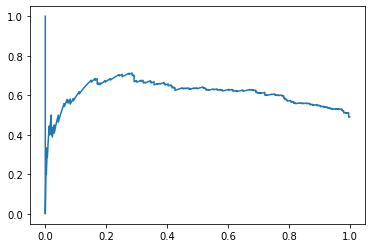

-----------------------------------------------------------------------------
synthesizer
	Val


,precision,recall,f1-score,support
0.0,0.575000,0.333333,0.422018,69.000000
1.0,0.748634,0.889610,0.813056,154.000000
accuracy,0.717489,0.717489,0.717489,0.717489
macro avg,0.661817,0.611472,0.617537,223.000000
weighted avg,0.694909,0.717489,0.692063,223.000000


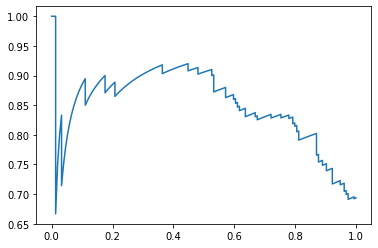


	Test


,precision,recall,f1-score,support
0.0,0.565217,0.464286,0.509804,112.000000
1.0,0.791667,0.850746,0.820144,268.000000
accuracy,0.736842,0.736842,0.736842,0.736842
macro avg,0.678442,0.657516,0.664974,380.000000
weighted avg,0.724924,0.736842,0.728675,380.000000


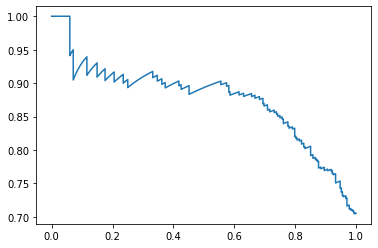

-----------------------------------------------------------------------------
trombone
	Val


,precision,recall,f1-score,support
0.0,0.685366,0.972318,0.804006,289.000000
1.0,0.578947,0.078571,0.138365,140.000000
accuracy,0.680653,0.680653,0.680653,0.680653
macro avg,0.632157,0.525445,0.471185,429.000000
weighted avg,0.650637,0.680653,0.586780,429.000000


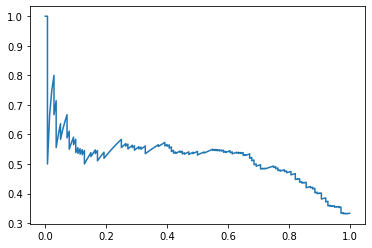


	Test


,precision,recall,f1-score,support
0.0,0.702541,0.955285,0.809647,492.000000
1.0,0.568627,0.127193,0.207885,228.000000
accuracy,0.693056,0.693056,0.693056,0.693056
macro avg,0.635584,0.541239,0.508766,720.000000
weighted avg,0.660135,0.693056,0.619089,720.000000


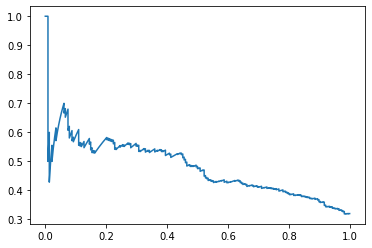

-----------------------------------------------------------------------------
trumpet
	Val


,precision,recall,f1-score,support
0.0,0.710914,0.816949,0.760252,295.000000
1.0,0.546218,0.398773,0.460993,163.000000
accuracy,0.668122,0.668122,0.668122,0.668122
macro avg,0.628566,0.607861,0.610623,458.000000
weighted avg,0.652300,0.668122,0.653747,458.000000


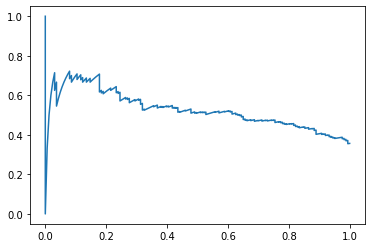


	Test


,precision,recall,f1-score,support
0.0,0.673647,0.826552,0.742308,467.000000
1.0,0.617925,0.411950,0.494340,318.000000
accuracy,0.658599,0.658599,0.658599,0.658599
macro avg,0.645786,0.619251,0.618324,785.000000
weighted avg,0.651074,0.658599,0.641857,785.000000


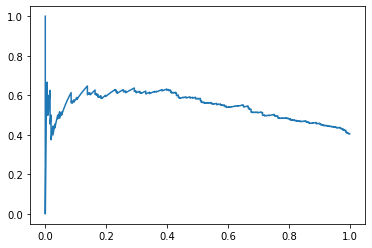

-----------------------------------------------------------------------------
ukulele
	Val


,precision,recall,f1-score,support
0.0,0.736677,0.890152,0.806175,264.000000
1.0,0.472727,0.236364,0.315152,110.000000
accuracy,0.697861,0.697861,0.697861,0.697861
macro avg,0.604702,0.563258,0.560663,374.000000
weighted avg,0.659045,0.697861,0.661756,374.000000


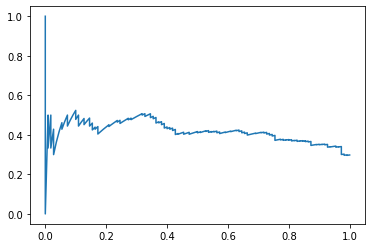


	Test


,precision,recall,f1-score,support
0.0,0.735887,0.894608,0.807522,408.000000
1.0,0.542553,0.280220,0.369565,182.000000
accuracy,0.705085,0.705085,0.705085,0.705085
macro avg,0.639220,0.587414,0.588544,590.000000
weighted avg,0.676249,0.705085,0.672424,590.000000


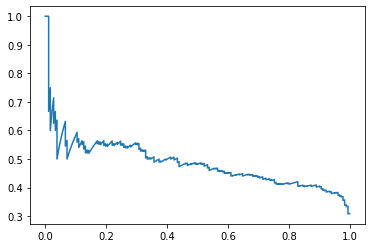

-----------------------------------------------------------------------------
violin
	Val


,precision,recall,f1-score,support
0.0,0.747126,0.507812,0.604651,128.000000
1.0,0.661290,0.848276,0.743202,145.000000
accuracy,0.688645,0.688645,0.688645,0.688645
macro avg,0.704208,0.678044,0.673927,273.000000
weighted avg,0.701536,0.688645,0.678241,273.000000


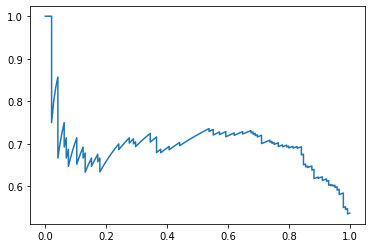


	Test


,precision,recall,f1-score,support
0.0,0.605714,0.447257,0.514563,237.000000
1.0,0.712719,0.824873,0.764706,394.000000
accuracy,0.683043,0.683043,0.683043,0.683043
macro avg,0.659217,0.636065,0.639634,631.000000
weighted avg,0.672529,0.683043,0.670754,631.000000


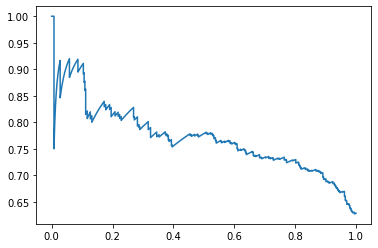

-----------------------------------------------------------------------------
voice
	Val


,precision,recall,f1-score,support
0.0,0.755556,0.390805,0.515152,87.000000
1.0,0.703911,0.919708,0.797468,137.000000
accuracy,0.714286,0.714286,0.714286,0.714286
macro avg,0.729733,0.655256,0.656310,224.000000
weighted avg,0.723969,0.714286,0.687819,224.000000


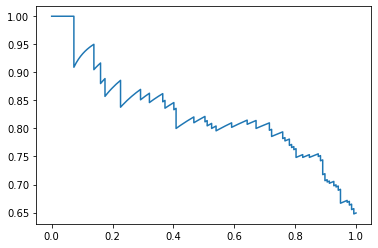


	Test


,precision,recall,f1-score,support
0.0,0.747126,0.433333,0.548523,150.000000
1.0,0.703833,0.901786,0.790607,224.000000
accuracy,0.713904,0.713904,0.713904,0.713904
macro avg,0.725480,0.667560,0.669565,374.000000
weighted avg,0.721197,0.713904,0.693514,374.000000


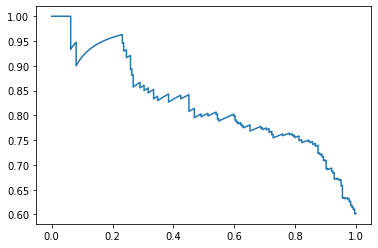

In [14]:
# Classwise results
# %%capture cap --no-stderr

from IPython.display import display, HTML

for instrument in class_map.keys():
    print('-' * 77)
    print(instrument)
    print('\tVal')
    display(HTML(pd.DataFrame(model_test_results['jigsaw_10_3_resnet_best']['val'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['jigsaw_10_3_resnet_best']['val'][4][instrument][1], model_test_results['jigsaw_10_3_resnet_best']['val'][4][instrument][0])
    plt.show()
    print('\n\tTest')
    display(HTML(pd.DataFrame(model_test_results['jigsaw_10_3_resnet_best']['test'][3][instrument]).T.to_html()))
    plt.plot(model_test_results['jigsaw_10_3_resnet_best']['test'][4][instrument][1], model_test_results['jigsaw_10_3_resnet_best']['test'][4][instrument][0])
    plt.show()
    
# with open('output.txt', 'w') as f:
#     f.write(cap.stdout)

In [7]:
!sh call_ssml_code.sh 'dsa'

Submitted batch job 6179404
Submitted batch job 6179405
Submitted batch job 6179406
Submitted batch job 6179407
Submitted batch job 6179408
Submitted batch job 6179409


In [33]:
model_file_path = './model/limited_dataset/'
for _, model_suffix, model_legend in model_path_list[:4]:
    results = pickle.load(open(model_file_path+model_suffix+'_trng_data_size_results.pkl', 'rb'))
    print(model_suffix, results.keys())
    temp_results = {}
    temp_results['val'], temp_results['test'] = {}, {}
    
    temp_results['val'] = results['val']
    
    # Calculate test performance & store results
    for key, values in temp_results['val'].items():
        model = AudioConvNet(fc=Identity())
        model.fc = SimpleMLP_Model(in_ftr=1024, out_ftr=20)
        model.load_state_dict(values['model_state_dict'])
        model.to(device)
    
        temp_results['test'][key] = test_model(Test_loader, model)
        
    print('Val: ', temp_results['val'].keys(), 'Test: ', temp_results['test'].keys())
    pickle.dump(temp_results, open(model_file_path+model_suffix+'_trng_data_size_results.pkl','wb'))

random_init dict_keys(['val', 'test'])
Val:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full']) Test:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full'])
time_reversal_best dict_keys(['val', 'test'])
Val:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full']) Test:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full'])
jigsaw_3_1_best dict_keys(['val', 'test'])
Val:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full']) Test:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full'])
jigsaw_10_3_wfc_best dict_keys(['val', 'test'])
Val:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full']) Test:  dict_keys([10, 50, 250, 500, 950, 1000, 'Full'])


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylabel'

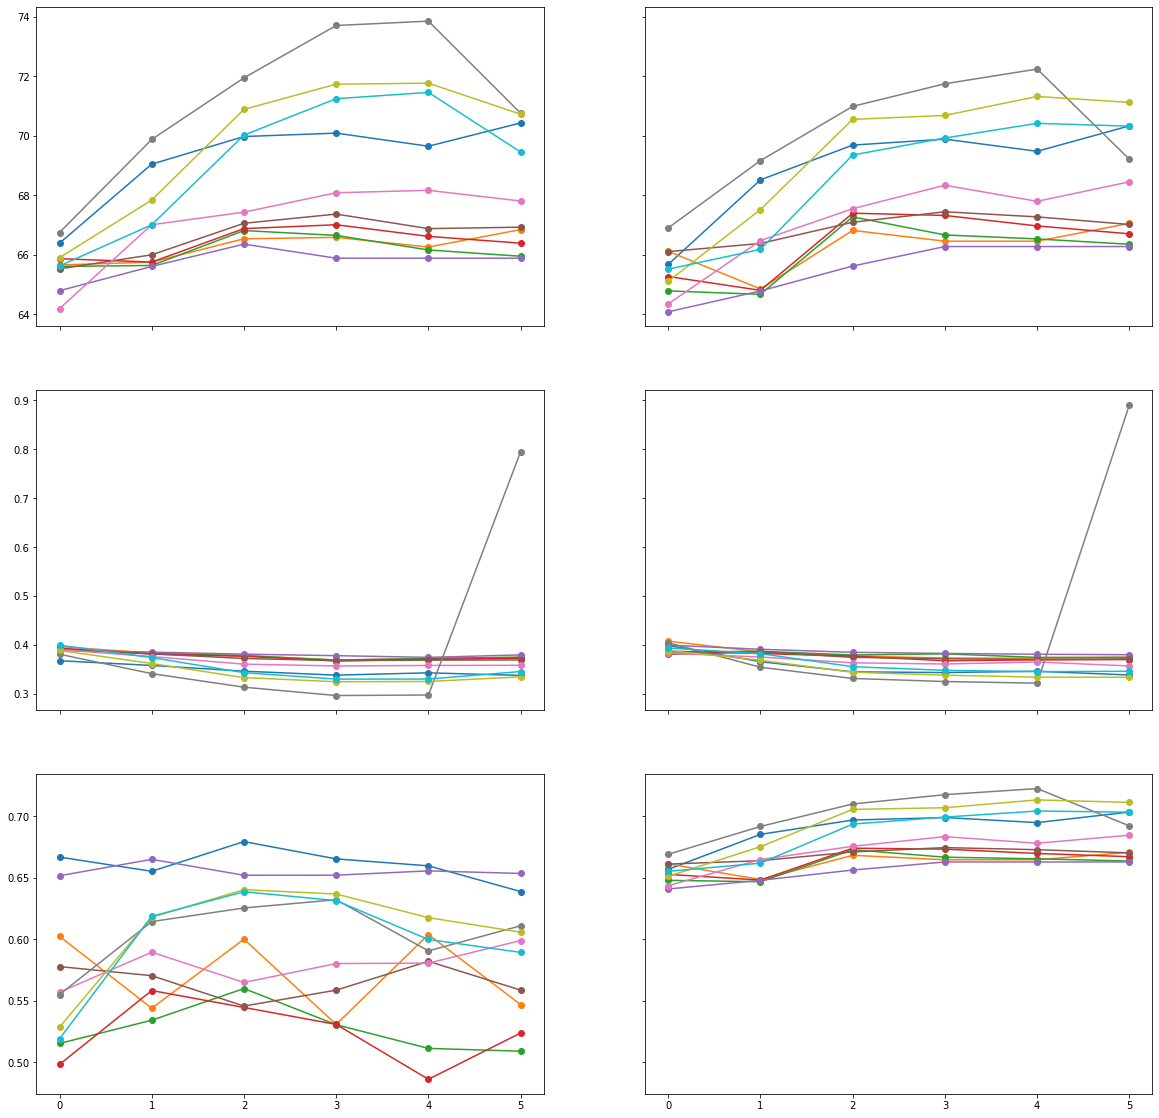

In [36]:
model_file_path = './model/limited_dataset/'

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 20), sharex='col', sharey='row')
plt_title = 'Data Size Validation Analysis'

for _, model_suffix, model_legend in model_path_list:
    results = pickle.load(open(model_file_path+model_suffix+'_trng_data_size_results.pkl', 'rb'))
    key_list = [10, 50, 250, 500, 950, 'Full']
    x = range(len(key_list))
    values = np.array(list(results.values()))

    ax[0,0].plot([max(results['val'][key]['val_acc_list']) for key in key_list], label=model_suffix, marker='o')
    ax[1,0].plot([min(results['val'][key]['val_loss_list']) for key in key_list], label=model_suffix, marker='o')
    ax[2,0].plot([min(results['val'][key]['val_f1_list']) for key in key_list], label=model_suffix, marker='o')
    
    ax[0,1].plot([results['test'][key][0] for key in key_list], label=model_suffix, marker='o')
    ax[1,1].plot([results['test'][key][1] for key in key_list], label=model_suffix, marker='o')
    ax[2,1].plot([results['test'][key][2] for key in key_list], label=model_suffix, marker='o')

#     if model_suffix == 'random_init':
#         # zip joins x and y coordinates in pairs
#         for xs,ys in zip(x,[max(value['val_acc_list']) for value in values]):

#             label = "{:.2f}".format(ys)

#             ax[0].annotate(label, # this is the text
#                          (xs,ys), # this is the point to label
#                          textcoords="offset points", # how to position the text
#                          xytext=(0,7), # distance from text to points (x,y)
#                          ha='center') # horizontal alignment can be left, right or center
            
#         for xs,ys in zip(x,[max(value['val_f1_list']) for value in values]):

#             label = "{:.2f}".format(ys)

#             ax[2].annotate(label, # this is the text
#                          (xs,ys), # this is the point to label
#                          textcoords="offset points", # how to position the text
#                          xytext=(0,7), # distance from text to points (x,y)
#                          ha='center') # horizontal alignment can be left, right or center

ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('Loss')
ax[2].set_ylabel('F1')
ax[1].legend(loc='best')

ax[2].set_xticks(x)    
ax[2].set_xticklabels(key_list)
ax[2].set_xlabel('Training Data Size')
    
ax[0].set_title(plt_title)

plt.savefig(results_path+plt_title.replace(' ', '_')+'.png')
plt.show()

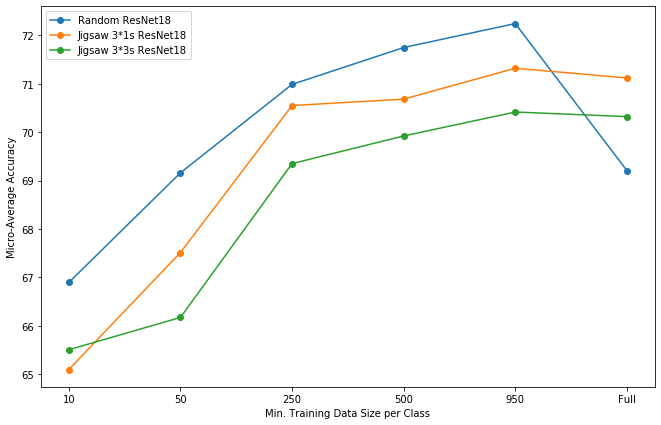

In [50]:
model_file_path = './model/limited_dataset/'

#Plot
fig = plt.figure()
fig.set_size_inches(11,7)

plt_title = 'Data Size Analysis-Test-ResNet'
key_list = [10, 50, 250, 500, 950, 'Full']
x = range(len(key_list))

for _, model_suffix, model_legend in model_path_list[7:]:
    results = pickle.load(open(model_file_path+model_suffix+'_trng_data_size_results.pkl', 'rb'))['test']

    plt.plot([results[key][0] for key in key_list], label=model_legend, marker='o')

plt.xlabel('Min. Training Data Size per Class')
plt.ylabel('Micro-Average Accuracy')
plt.legend(loc='best')
plt.xticks(x, key_list)

# # # zip joins x and y coordinates in pairs
# for xs,ys in zip(x,[value['test'][0] for value in values]):

#     label = "{:.2f}".format(ys)

#     plt.annotate(label, # this is the text
#                  (xs,ys), # this is the point to label
#                  textcoords="offset points", # how to position the text
#                  xytext=(0,7), # distance from text to points (x,y)
#                  ha='center') # horizontal alignment can be left, right or center

plt.savefig(results_path+plt_title.replace(' ', '_')+'.png')
plt.show()